# Overview

The aim of the following analysis is to formulate an investment strategy on the Warsaw Stock Exchange using data on a given company from its quarterly financial reports. The analysed dataset is based on information from the website biznesradar.pl and covers 69 quarters from Q4 2004 to Q4 2021. Analysis of the gurus' strategies proved that it is possible to select indices in such a way as to outperform the Warsaw Stock Exchange Index. However, the analysed strategies used only a fraction of the available indicators and, moreover, their original versions were developed on the basis of experience from the NYSE. It may be that other indicators, overlooked by the analysed strategies, are relevant for the WSE.

The analysed dataset does not have a target feature by default. Such a variable - in simple terms - is the share price dynamics of a given company. We want to find out which indicators make the dynamics positive (i.e. what suggests that a given company may be an interesting investment) and which ones make the dynamics negative (i.e. what we need to pay attention to so that our investment does not result in a loss).

A rule of thumb attributed to Benjamin Graham says that we should assume a certain level of return we want to achieve and a certain period of time we give to the investment - more specifically 50-100% over 2-3 years at most. This means that we will sell shares in a particular company either when we have reached our assumed level of profit or when the assumed time period has elapsed (whatever the return on such an investment is). In addition, we should have at least 10 companies in our portfolio. Initial analysis of the gurus' strategies has shown that a reasonable assumption is that our investment should achieve a profit of 50% within a year.

When considering the creation of a target feature, we must start with two variables. The **price_dynamics_y** feature represents dynamics of price after the following year, e.g. dynamics between Q1 2020 and Q1 2021. The **best_price_dynamics_y** feature represents the best scenario dynamics of price in the following year, i.e.
- if in Q1 2020 company's price was 100, and in the next four quarters (i.e. Q2 2020, Q3 2020, Q4 2020 and Q1 2021) it was 101, 105, 103 and 104 respectively, the **best_price_dynamics_y** would be 0.05 (i.e. (105 - 100) / 100);
- if in Q1 2020 company's price was 100, and in the next four quarters (i.e. Q2 2020, Q3 2020, Q4 2020 and Q1 2021) it was 95, 96, 97 and 90 respectively, the **best_price_dynamics_y** would be -0.03 (i.e. (97 - 100) / 100).

The **adj_best_price_dynamics_y** and **adj_price_dynamics_y** features represent **best_price_dynamics_y** and **price_dynamics_y** adjusted by capital gains tax (19% in Poland) and inflation rate. It does not include transaction fees, as they may vary depending on broker, transaction value etc.

Making the above assumptions, we can create the following variables:
- **final_price_dynamics** takes value of 0.5 if **adj_best_price_dynamics_y** exceeds it and **price_dynamics_y** otherwise, i.e. if the company's share price has risen by more than 50% in a year, this means that we have sold the shares with this return, while if not, we have sold them after a year of buying.
- **interesting_company** is a variable which takes *Yes* if given company make a profit above 50%, *Maybe* if company make a profit below 50% (or does not make a loss) and *No* if company make a loss.

There will be also two additional variables:
- **sold_in_q** denotes the quarter in which the company's shares were sold (i.e. the quarter in which the company's price rose by 50% or the quarter one year after the purchase).
- **final_wig_dynamics** equivalent to **final_price_dynamics**, but referring to the WIG and not a given company.

In this part of analysis, using classification methods, we will try to correctly assign the status of the variable **interesting_company** and see if the resulting model will be better than gurus' strategies. 

Recall that the so-called zero effort strategy (i.e. a stock index investment) produced an average return of 5.6% and made losses in 38% of the quarters analysed. In contrast, the best analysed strategy - the modified Kirkpatrick's strategy - yielded an average profit of 18%, made losses in 23% of the analysed quarters and 30% of the buy signals would end in a loss. The next best strategy - the modified Zweig's strategy - yielded an average profit of 15%, made losses in 19% of the analysed quarters and 34% of the buy signals would end in a loss.

### Packages & dataset loading

In [1]:
"""Packages loading"""
import glob
from itertools import combinations
import os
from textwrap import TextWrapper

import dalex as dx
import joblib
from lazypredict.Supervised import LazyClassifier
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import ClassifierMixin
from sklearn.compose import ColumnTransformer
import sklearn.ensemble as ens
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import KNNImputer, SimpleImputer
import sklearn.metrics as skm
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, power_transform, PowerTransformer, StandardScaler
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.utils import all_estimators, class_weight, resample
import xgboost as xgb

In [2]:
# Additional settings
xgb.set_config(verbosity=0)
pd.set_option('display.float_format', '{:.4f}'.format)

In [3]:
# Dataset loading (the newest full dataset)
dataset = pd.read_csv(
    max(
        glob.glob(os.getcwd().replace('analysis', '') + 'data\\full_datasets\\*.csv'),
        key = os.path.getctime
    ),
    index_col=False,
    low_memory=False
)

### Auxilliary functions

In [25]:
def preprocessor(temp_dataset, drop_subset, treshold):
    """All initial transformations"""
    # temp_dataset = copy of the original dataset
    # non_num_columns = non-numeric columns
    # div_columns = dividend columns
    # drop_subset = target and auxilliary columns to be removed from X sets
    # treshold = % of observations with missing values

    # Fixing bug resulting from dividing the features
    # In some values dot is replaced by comma and whole column gets wrong data type
    temp_dataset.replace(',', '.', regex=True, inplace=True)
    subset = temp_dataset.columns[~temp_dataset.columns.isin([
        'quarter', 'company_code', 'best_price_dynamics_in_q',
        'price_dynamics_y_in_q', 'country', 'industry'
    ])]
    temp_dataset[subset] = temp_dataset[subset].astype(float)
    temp_dataset = temp_dataset.replace([np.inf, -np.inf], np.nan)

    # Fill NAs in dividend data with 0 (NA here means that dividend most probably wasn't paid)
    # The same for positive net earnings in previous years
    cat_cols = [
        'dividend_1Y', 'continuous_dividend', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y',
        'pos_net_earnings_3Y', 'pos_net_earnings_2Y', 'pos_net_earnings_1Y',
        'continuous_price_growth'
    ]
    for col in cat_cols:
        temp_dataset[col] = temp_dataset[col].fillna(0)

    # There is a wrong price reported by company FMG in Q4 2018. The company reported price at
    # 0.15 - however, in neighbouring quarters it was 30.93 and 28. Checking this information
    # on another stock exchange website (stooq.pl) confirms that this is an incorrect value
    # - this company was listed on the stock exchange only once in Q4 2018, but with a price of
    # 29, which is a better approximation of the real price.
    idx = temp_dataset.loc[
        np.where(
            (temp_dataset.company_code == 'FMG')
            & (temp_dataset.quarter == '2018/Q4')
        )
    ].index[0]
    temp_dataset.loc[idx, 'price'] = 29
    temp_dataset.loc[idx, 'best_price_dynamics_y'] = (28 - 29) / 29
    temp_dataset.loc[idx, 'price_dynamics_y'] = (9 - 29) / 29

    # Adding new features
    dynamics = {
        'adj_best_price_dynamics_y':
        81 * temp_dataset.best_price_dynamics_y / temp_dataset.inflation_yy_m,
        'adj_price_dynamics_y':81 * temp_dataset.price_dynamics_y / temp_dataset.inflation_yy_m,
        'adj_best_wig_dynamics_y':
        81 * temp_dataset.best_wig_dynamics_y / temp_dataset.inflation_yy_m,
        'adj_wig_dynamics_y':81 * temp_dataset.wig_dynamics_y / temp_dataset.inflation_yy_m,
        'final_price_dynamics':pd.Series(
            np.where(
                81 * temp_dataset.best_price_dynamics_y / temp_dataset.inflation_yy_m > .5,
                .5, 81 * temp_dataset.price_dynamics_y / temp_dataset.inflation_yy_m
            )
        ),
        'final_wig_dynamics':pd.Series(
            np.where(
                81 * temp_dataset.best_wig_dynamics_y / temp_dataset.inflation_yy_m > .5,
                .5, 81 * temp_dataset.wig_dynamics_y / temp_dataset.inflation_yy_m
            )
        ),
        'sold_in_q':pd.Series(np.where(
            81 * temp_dataset.best_price_dynamics_y / temp_dataset.inflation_yy_m > .5,
            temp_dataset.best_price_dynamics_in_q,
            temp_dataset.price_dynamics_y_in_q
        ))
    }
    dynamics = pd.DataFrame(dynamics)

    dynamics['interesting_investment'] = pd.Categorical(
        pd.Series(
            np.where(
                dynamics.final_price_dynamics == .5,
                'Yes', np.where(
                    dynamics.final_price_dynamics >= 0,
                    'Maybe', 'No'
                )
            )
        ),
        categories=['No', 'Maybe', 'Yes'],
        ordered=True
    )

    temp_dataset = pd.concat(
        [temp_dataset, pd.DataFrame(dynamics, index=temp_dataset.index)],
        axis=1
    )

    # Removing variables with more than x% missing values
    temp_dataset.dropna(thresh=len(temp_dataset) * treshold, axis=1, inplace=True)

    # Down-sample majority classes
    n_samples = len(temp_dataset[temp_dataset.interesting_investment == 'Yes'])

    temp_class_no = resample(
        temp_dataset[temp_dataset.interesting_investment == 'No'],
        replace=False,
        n_samples=n_samples,
        random_state=1234
    )

    temp_class_maybe = resample(
        temp_dataset[temp_dataset.interesting_investment == 'Maybe'],
        replace=False,
        n_samples=n_samples,
        random_state=1234
    )

    temp_dataset = pd.concat([
        temp_class_no,
        temp_class_maybe,
        temp_dataset[temp_dataset.interesting_investment == 'Yes']
    ])

    # Train test split
    # Target features kept in X_set for train-validation split
    X_set = temp_dataset.copy()
    y_set = temp_dataset.filter(['interesting_investment'])

    X_train, X_test, y_train, y_test = train_test_split(
        X_set, y_set, test_size=.15, random_state=1234,
        shuffle=True, stratify=y_set.interesting_investment
    )

    # Creating X_test_set
    y_clf_test = X_test.filter(['interesting_investment'])
    X_test.drop(drop_subset, axis=1, errors='ignore', inplace=True)

    test_set = (X_test, y_clf_test)

    # Train validation split
    X_set = X_train.copy()
    y_set = X_train.filter(['interesting_investment'])

    X_train, X_val, y_train, y_val = train_test_split(
        X_set, y_set, test_size=.15, random_state=1234,
        shuffle=True, stratify=y_set.interesting_investment
    )

    # Creating X_train_set
    y_clf_train = X_train.filter(['interesting_investment'])
    X_train.drop(drop_subset, axis=1, errors='ignore', inplace=True)

    train_set = (X_train, y_clf_train)

    # Creating X_val_set
    y_clf_val = X_val.filter(['interesting_investment'])
    X_val.drop(drop_subset, axis=1, errors='ignore', inplace=True)

    val_set = (X_val, y_clf_val)

    return temp_dataset, train_set, val_set, test_set

In [5]:
def mi_scores(x_train, y_train):
    """MI scores calculation and presenatation"""
    x_train_fact = x_train.copy()
    for col in x_train_fact.select_dtypes('category'):
        x_train_fact[col], _ = x_train_fact[col].factorize()
    discrete_feat = x_train_fact.dtypes == int

    mi_scores = pd.DataFrame(
        mutual_info_classif(
            x_train,
            y_train,
            discrete_features=discrete_feat,
            random_state=1234
        ),
        columns=['MI Scores'],
        index=x_train.columns
    ).sort_values(by='MI Scores', ascending=False)

    mi_scores_0 = mi_scores[mi_scores['MI Scores']>0].count()[0]
    mi_scores_05 = mi_scores[mi_scores['MI Scores']>.05].count()[0]

    print(f'Number of features with MI score greater than 0: {mi_scores_0}')
    print(f'Number of features with MI score greater than 0.05: {mi_scores_05}')
    print('\nFeatures with top MI scores:')
    print(mi_scores[mi_scores['MI Scores']>.05])

    labels = [
        '\n'.join(wrap(el.replace('_', ' '), 120))
        for el in mi_scores[mi_scores['MI Scores']>.05]['MI Scores'].index.tolist()
    ]

    fig, ax = plt.subplots(figsize=(14, 6))

    sns.barplot(
        x=mi_scores[mi_scores['MI Scores']>.05]['MI Scores'],
        y=labels,
        color='blue',
        ax=ax
    )

    ax.set_ylabel('Feature')
    plt.suptitle('Mutual Information Scores')

    plt.tight_layout();

    return mi_scores

In [281]:
def model_results(model, x_train, x_val, y_train, y_val, return_results):
    """ROC AUC and CLF report for any classification model"""

    y_train_num = y_train.interesting_investment.cat.rename_categories({'No':0, 'Maybe':1, 'Yes':2})
    y_val_num = y_val.interesting_investment.cat.rename_categories({'No':0, 'Maybe':1, 'Yes':2})

    train_classes_weight = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_train_num
    )
    val_classes_weight = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_val_num
    )

    train_pred = pd.DataFrame(model.predict(x_train), columns=['prediction'], index=x_train.index)
    val_pred = pd.DataFrame(model.predict(x_val), columns=['prediction'], index=x_val.index)

    train_pred_relabel = train_pred.replace({'prediction':{0:'No', 1:'Maybe', 2:'Yes'}})
    val_pred_relabel = val_pred.replace({'prediction':{0:'No', 1:'Maybe', 2:'Yes'}})

    train_ct = pd.crosstab(
        y_train.interesting_investment,
        train_pred_relabel.prediction,
        rownames=['Interesting investment:'],
        colnames=['Prediction:']
    ).reindex(['No', 'Maybe', 'Yes'], axis=1)

    val_ct = pd.crosstab(
        y_val.interesting_investment,
        val_pred_relabel.prediction,
        rownames=['Interesting investment:'],
        colnames=['Prediction:']
    ).reindex(['No', 'Maybe', 'Yes'], axis=1)

    train_precision = skm.precision_score(
        y_train_num,
        train_pred,
        labels=[2],
        average='macro',
        sample_weight=train_classes_weight
    )

    val_precision = skm.precision_score(
        y_val_num,
        val_pred,
        labels=[2],
        average='macro',
        sample_weight=val_classes_weight
    )

    if not return_results:
        print(f'Model\'s precision for class Yes on training set: {round(train_precision, 4)}')
        display(train_ct)
        print(f'\nModel\'s precision for class Yes on validation set: {round(val_precision, 4)}')
        display(val_ct)
    else:
        return train_precision, val_precision

In [38]:
def xgb_simple(x_train, y_train, x_val, y_val, model_name):
    """Simple calculation of ROC AUC and CLF report from XGB to quickly look at any improvements"""

    y_train_num = y_train.interesting_investment.cat.rename_categories({'No':0, 'Maybe':1, 'Yes':2})
    y_val_num = y_val.interesting_investment.cat.rename_categories({'No':0, 'Maybe':1, 'Yes':2})

    train_classes_weight = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_train_num
    )
    val_classes_weight = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_val_num
    )

    model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=1234)
    model.fit(x_train, y_train_num, sample_weight=train_classes_weight)

    train_pred = pd.DataFrame(model.predict(x_train), columns=['prediction'], index=x_train.index)
    val_pred = pd.DataFrame(model.predict(x_val), columns=['prediction'], index=x_val.index)

    train_pred_relabel = train_pred.replace({'prediction':{0:'No', 1:'Maybe', 2:'Yes'}})
    val_pred_relabel = val_pred.replace({'prediction':{0:'No', 1:'Maybe', 2:'Yes'}})

    train_ct = pd.crosstab(
        y_train.interesting_investment,
        train_pred_relabel.prediction,
        rownames=['Interesting investment:'],
        colnames=['Prediction:']
    ).reindex(['No', 'Maybe', 'Yes'], axis=1)

    val_ct = pd.crosstab(
        y_val.interesting_investment,
        val_pred_relabel.prediction,
        rownames=['Interesting investment:'],
        colnames=['Prediction:']
    ).reindex(['No', 'Maybe', 'Yes'], axis=1)

    train_precision = skm.precision_score(
        y_train_num,
        train_pred,
        labels=[2],
        average='macro',
        sample_weight=train_classes_weight
    )

    val_precision = skm.precision_score(
        y_val_num,
        val_pred,
        labels=[2],
        average='macro',
        sample_weight=val_classes_weight
    )

    print(f'Model\'s precision for class Yes on training set: {round(train_precision, 4)}')
    display(train_ct)
    print(f'\nModel\'s precision for class Yes on validation set: {round(val_precision, 4)}')
    display(val_ct)

In [103]:
def xgb_results(x_train, y_train, x_val, y_val):
    """XGB performance for KNN imputation"""

    y_train_num = y_train.interesting_investment.cat.rename_categories({'No':0, 'Maybe':1, 'Yes':2})
    y_val_num = y_val.interesting_investment.cat.rename_categories({'No':0, 'Maybe':1, 'Yes':2})

    train_classes_weight = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_train_num
    )
    val_classes_weight = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_val_num
    )

    model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=1234)
    model.fit(x_train, y_train_num, sample_weight=train_classes_weight)

    train_pred = pd.DataFrame(model.predict(x_train), columns=['prediction'], index=x_train.index)
    val_pred = pd.DataFrame(model.predict(x_val), columns=['prediction'], index=x_val.index)

    train_precision = skm.precision_score(
        y_train_num,
        train_pred,
        labels=[2],
        average='macro',
        sample_weight=train_classes_weight
    )

    val_precision = skm.precision_score(
        y_val_num,
        val_pred,
        labels=[2],
        average='macro',
        sample_weight=val_classes_weight
    )

    return train_precision, val_precision

# Dataset preprocessing

The analysed dataset contains 18526 observations and 415 features. There is 409 numeric variables and 6 non-numeric variables:
- **quarter** is the period covered by the data of the given company;
- **company_code** is the code of the given company;
- **best_price_dynamics_in_q** denotes the period in which the company made the highest profit during the year;
- **price_dynamics_y_in_q** denotes the period one year after the purchase of shares of the given company;
- **country** denotes the country of the company in question (the company may not be from Poland, but may be listed on the Warsaw Stock Exchange);
- **industry** denotes the industry of the company in question.

Features relating to future dynamics will be omitted to avoid data leakage (i.e. when deciding to buy a share, we do not know when exactly we will sell it or what return we will achieve). The variables **quarter** and **company_code** will not be included in any model. The variables **country** and **industry** will be one-hot encoded.

In addition, there are numeric variables in the dataset, which will be ordinally encoded: **continuous_dividend** and **continuous_price_growth**, specifying the number of quarters with, respectively, continuous dividend payments and continuous share price growth of a given company. In addition, there are also variables that will be converted into binary: **dividend_1Y** (whether a dividend was paid by the company in the previous year) and **pos_net_earnings_5Y**, **pos_net_earnings_4Y**, **pos_net_earnings_3Y**, **pos_net_earnings_2Y**, **pos_net_earnings_1Y** (whether the company had positive net earnings 5 years ago, 4 years ago, etc.). Missing values in these variables will be replaced by zeros.

In [9]:
print('Basic information about the analysed dataset:')
dataset.info()

Basic information about the analysed dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18526 entries, 0 to 18525
Columns: 415 entries, quarter to avg_price_earnings
dtypes: float64(407), int64(2), object(6)
memory usage: 58.7+ MB


In [10]:
print('Features of \'object\' data type:')
dataset.select_dtypes('object')

Features of 'object' data type:


,quarter,company_code,best_price_dynamics_in_q,price_dynamics_y_in_q,country,industry
0,2004/Q4,06N,2005/Q1,2005/Q4,PL,investment
1,2004/Q4,OCTAVA,2005/Q1,2005/Q4,PL,real_easte
2,2004/Q4,AAT,2005/Q1,2005/Q4,PL,real_easte
3,2004/Q4,ASSECO-POLAND,2005/Q1,2005/Q4,PL,information_tech
4,2004/Q4,AGORA,2005/Q1,2005/Q4,PL,media
...,...,...,...,...,...,...
18521,2005/Q3,LUBAWA,2006/Q1,2006/Q3,PL,clothing_cosmetics
18522,2005/Q3,MUZA,2006/Q1,2006/Q3,PL,media
18523,2021/Q4,PCO,2022/Q1,2022/Q4,NL,commercial_network
18524,2021/Q4,SYNEKTIK,2022/Q1,2022/Q4,PL,biotechnology


95% of the variables have missing values and 26% of the features have more than 50% missing values. These are mainly due to two reasons:
- the company did not report data on the variable (or the data needed to create the feature);
- it is a variable such as **price_avg_earnings_share_10Y**, which represents the ratio of share price to average earnings per share over the last 10 years, then observations up to 2015 will not include data on this feature.

The variables needed to create target features (**best_price_dynamics_y**, **price_dynamics_y**, **inflation_yy_m**) do not have missing values, such as the variables intended for one-hot encoding.

In [11]:
print('Percentage of features with missing values: '\
    f'{round(100 * dataset.isna().any().sum() / len(dataset.columns), 2)}%')
print('Percentage of features with more than 50% missing values: '\
    f'{round(100 * (dataset.isna().sum() > .5 * len(dataset)).sum() / len(dataset.columns), 2)}%')
print('Percentage of missing values in preliminary target features:')
print(round(100 * dataset.filter([
    'best_price_dynamics_y',
    'price_dynamics_y'
]).isna().sum() / len(dataset.columns), 2))
print('Percentage of missing values in inflation feature: '\
    f'{round(100 * dataset.inflation_yy_m.isna().any().sum() / len(dataset.columns), 2)}%')
print('Percentage of missing values in quarter feature: '\
    f'{round(100 * dataset.quarter.isna().any().sum() / len(dataset.columns), 2)}%')
print('Percentage of missing values in country feature: '\
    f'{round(100 * dataset.country.isna().any().sum() / len(dataset.columns), 2)}%')
print('Percentage of missing values in industry feature: '\
    f'{round(100 * dataset.industry.isna().any().sum() / len(dataset.columns), 2)}%')
print('Percentage of duplicate rows: '\
    f'{round(100 * dataset.duplicated().sum() / len(dataset.columns), 2)}%')

Percentage of features with missing values: 94.22%
Percentage of features with more than 50% missing values: 25.78%
Percentage of missing values in preliminary target features:
best_price_dynamics_y   0.0000
price_dynamics_y        0.0000
dtype: float64
Percentage of missing values in inflation feature: 0.0%
Percentage of missing values in quarter feature: 0.0%
Percentage of missing values in country feature: 0.0%
Percentage of missing values in industry feature: 0.0%
Percentage of duplicate rows: 0.0%


The analysed dataset requires several initial transformations:
- During saving the dataset after downloading data, an error occurs: it substitutes a dot for a comma in some cells, and the given variable has a data type of *str* instead of *float*.
- Missing values in variables intended for ordinal encoding and conversion into dummy features will be replaced with zeros.
- The FMG company in Q4 2018 has an incorrect share price value reported, this will be replaced with the correct value and the price dynamics will be recalculated for this item.
- The target features and auxiliary variables will be added.

As we remember from the analysis of the gurus' strategies, the ratio of classes from the **interesting_investment** variable was as follows: *No* 52%, *Maybe* 32%, *Yes* 16%. For this reason, we will down-sample *No* and *Maybe* classes, and then divide the dataset into training, validation and test sets, so that in each of them each class has the same size.

As the histogram below shows, most variables have less than 50% missing values. However, the proportion of variables having more than 95% missing values is significant. Variables with a high percentage of missing values will be problematic especially after splitting into training, validation and test sets - especially the latter may lack enough values to decently impute such variables. Hence, variables containing more than 50% of missing values will be removed from the set. 

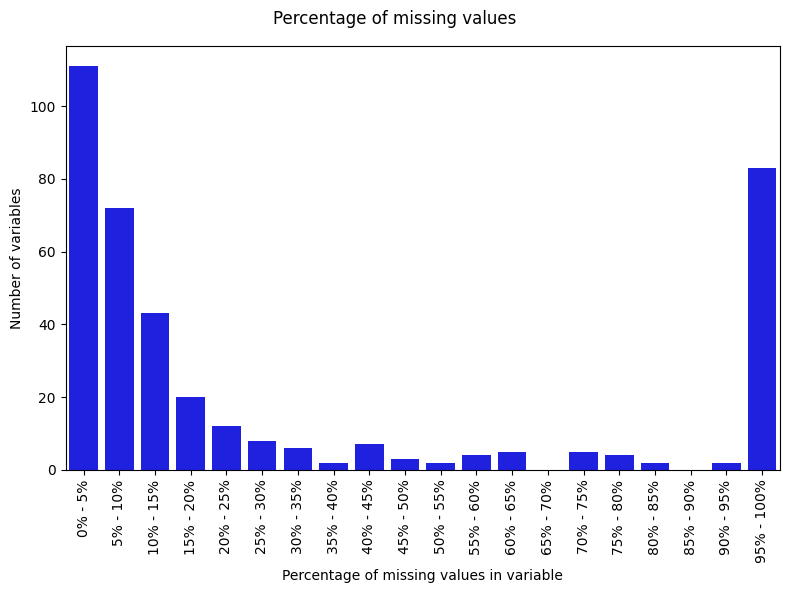

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(
    x=pd.cut(
        dataset.isna().sum() / len(dataset),
        bins=list(np.arange(0, 1.05, .05)),
        labels=[f'{i}% - {i+5}%' for i in range(0, 100, 5)]
    ),
    color='blue',
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Percentage of missing values in variable')
ax.set_ylabel('Number of variables')

plt.suptitle('Percentage of missing values')

plt.tight_layout();

In [28]:
# Preprocessing - remove variables with more than 50% missing values
dataset_preproc = dataset.copy()
dataset_preproc, train_set, val_set, test_set = preprocessor(
    temp_dataset = dataset_preproc,
    drop_subset = [
        'best_price_dynamics_y', 'price_dynamics_y', 'best_price_dynamics_in_q',
        'price_dynamics_y_in_q', 'inflation_yy_m', 'usd_pln', 'wig', 'wig_6m',
        'best_wig_dynamics_y', 'wig_dynamics_y', 'adj_best_price_dynamics_y',
        'adj_price_dynamics_y', 'adj_best_wig_dynamics_y', 'adj_wig_dynamics_y',
        'final_wig_dynamics', 'sold_in_q', 'final_price_dynamics',
        'interesting_investment', 'avg_price_earnings', 'quarter', 'company_code'
    ] + dataset_preproc.filter(regex='rank').columns.tolist(),
    treshold = .5
)

# Unpacking sets
X_train, y_clf_train = train_set
X_val, y_clf_val = val_set
X_test, y_clf_test = test_set

# Dataset exploration

The transformed training set has 286 numeric variables, 2 object variables and 6523 observations. 92% of the variables and 97% of the observations have missing values. There are no duplicated rows in the set.

The **interesting_investment** variable has 2175 *No* observations, 2174 *Maybe* observations and 2174 *Yes* observations (16.24%).

In [29]:
print('Basic information about the analysed dataset:')
X_train.info()
print('\nPercentage of features with missing values: '\
    f'{round(100 * X_train.isna().any().sum() / len(X_train.columns), 2)}%')
print('Percentage of features with more than 50% missing values: '\
    f'{round(100 * (X_train.isna().sum() > .5 * len(X_train)).sum() / len(X_train.columns), 2)}%')
print('Percentage of observations with missing values: '\
    f'{round(100 * X_train.isna().any(axis=1).sum() / len(X_train), 2)}%')
print('Percentage of missing values in classification target feature: '\
    f'{round(100 * y_clf_train.interesting_investment.isna().sum() / len(y_clf_train), 2)}%')
print('Percentage of duplicate rows: '\
    f'{round(100 * X_train.duplicated().sum() / len(X_train.columns), 2)}%')

Basic information about the analysed dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6523 entries, 4295 to 17583
Columns: 288 entries, price_dynamics_6m to price_avg_earnings_share_6Y
dtypes: float64(286), object(2)
memory usage: 14.4+ MB

Percentage of features with missing values: 92.36%
Percentage of features with more than 50% missing values: 1.04%
Percentage of observations with missing values: 97.04%
Percentage of missing values in classification target feature: 0.0%
Percentage of duplicate rows: 0.0%


In [30]:
print('Basic statistics of final_price_dynamics feature:')
print(y_clf_train.value_counts())
print(100 * y_clf_train.value_counts(normalize=True))

Basic statistics of final_price_dynamics feature:
interesting_investment
Maybe                     2175
No                        2174
Yes                       2174
dtype: int64
interesting_investment
Maybe                    33.3436
No                       33.3282
Yes                      33.3282
dtype: float64


# Feature engineering

## Imputing & encoding

In the first step, we will replace the missing values using the K-nearest neighbours method (with k = 100). We will follow this approach throughout the feature engineering and variable selection process, and then see if we can find a better method for replacing missing values for the chosen features. Missing indicators will be added to the dataset. Then the **country** and **industry** variables will be one-hot encoded, while the other categorical variables will be given the appropriate data type. The dataset thus transformed has 613 variables, 335 of which are categorical.

In [31]:
# Imputing & encoding

# Categorical data
cat_cols = [
    'dividend_1Y', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y', 'pos_net_earnings_3Y',
    'pos_net_earnings_2Y', 'pos_net_earnings_1Y', 'country', 'industry', 'continuous_dividend',
    'continuous_price_growth'
]

# Scaling numerical data
train_means = X_train.drop(cat_cols, axis=1, errors='ignore').mean()
train_stds = X_train.drop(cat_cols, axis=1, errors='ignore').std()

X_train_scaled = (X_train.drop(cat_cols, axis=1, errors='ignore') - train_means) / train_stds
X_val_scaled = (X_val.drop(cat_cols, axis=1, errors='ignore') - train_means) / train_stds

X_train_scaled = pd.concat([X_train.filter(cat_cols), X_train_scaled], axis=1)
X_val_scaled = pd.concat([X_val.filter(cat_cols), X_val_scaled], axis=1)

imp_enc_pipe = ColumnTransformer(
    transformers=[
        (
            'knn_imputer',
            KNNImputer(n_neighbors=100, weights='distance', add_indicator=True),
            X_train_scaled.drop(cat_cols, axis=1).columns.to_list()
        ),
        (
            'oh_encoder',
            OneHotEncoder(handle_unknown='infrequent_if_exist'),
            ['country', 'industry']
        )
    ],
    remainder='passthrough'
)

X_train_proc = pd.DataFrame(
    imp_enc_pipe.fit_transform(X_train_scaled),
    index=X_train_scaled.index,
    columns=[col_name.split('__', 1)[1] for col_name in imp_enc_pipe.get_feature_names_out()]
)
X_val_proc = pd.DataFrame(
    imp_enc_pipe.transform(X_val_scaled),
    index=X_val_scaled.index,
    columns=[col_name.split('__', 1)[1] for col_name in imp_enc_pipe.get_feature_names_out()]
)

cat_cols_updated = [
    *cat_cols,
    *X_train_proc.filter(regex='country').columns.tolist(),
    *X_train_proc.filter(regex='industry').columns.tolist(),
    *X_train_proc.filter(regex='missingindicator').columns.tolist()
]

# Scale data back
X_train_proc = pd.concat(
    [
        X_train_proc.filter(cat_cols_updated),
        X_train_proc.drop(cat_cols_updated, axis=1, errors='ignore') * train_stds + train_means
    ],
    axis=1
)
X_val_proc = pd.concat(
    [
        X_val_proc.filter(cat_cols_updated),
        X_val_proc.drop(cat_cols_updated, axis=1, errors='ignore') * train_stds + train_means
    ],
    axis=1
)

# Converting dummy cols to category
dummy_cols = [
    'dividend_1Y', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y', 'pos_net_earnings_3Y',
    'pos_net_earnings_2Y', 'pos_net_earnings_1Y'
] + X_train_proc.filter(
    regex='country'
).columns.tolist() + X_train_proc.filter(
    regex='industry'
).columns.tolist() + X_train_proc.filter(regex='missingindicator').columns.tolist()

X_train_proc[dummy_cols] = X_train_proc[dummy_cols].astype('category')
X_val_proc[dummy_cols] = X_val_proc[dummy_cols].astype('category')

# Converting 'continuous' to ordered category
for col in ['continuous_dividend', 'continuous_price_growth']:
    X_train_proc[col] = pd.Categorical(
        X_train_proc[col],
        categories=set(X_train_proc[col]),
        ordered=True
    )
    X_val_proc[col] = pd.Categorical(
        X_val_proc[col],
        categories=set(X_val_proc[col]),
        ordered=True
    )

# Change numeric features back to float type
num_cols = [
    col for col in X_train_proc.columns if col not in 
    dummy_cols + ['continuous_dividend', 'continuous_price_growth']
]
X_train_proc[num_cols] = X_train_proc[num_cols].astype('float64')
X_val_proc[num_cols] = X_val_proc[num_cols].astype('float64')

In [32]:
X_train_proc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6523 entries, 4295 to 17583
Columns: 613 entries, dividend_1Y to price_avg_earnings_share_6Y
dtypes: category(335), float64(278)
memory usage: 16.0 MB


## Benchmark model

Extreme gradient boosting (XGB) built on the training set with default parameters will serve as a benchmark for subsequent classification models. The models will be evaluated using precision score for class *Yes*. We will measure the quality of the prediction on both the training set and the validation set. After each transformation, we will check whether the quality of the model has improved over the benchmark model. The gurus' strategies generally used at most a few indicators - we will follow this pattern and use only the variables with the MI score greater than 0.05.

406 variables achieved a positive MI score, while only 3 of them achieved an MI score greater than 0.05: **supplementary_capital**, **number_of_shares** and **core_capital**. The precision score for class *Yes* on the training set is 0.7385, while on the validation set is 0.5371. In the next steps, we will try to modify the datasets in such a way as to increase the value of the metrics.

Number of features with MI score greater than 0: 406
Number of features with MI score greater than 0.05: 3

Features with top MI scores:
                       MI Scores
supplementary_capital     0.1066
number_of_shares          0.0984
core_capital              0.0972


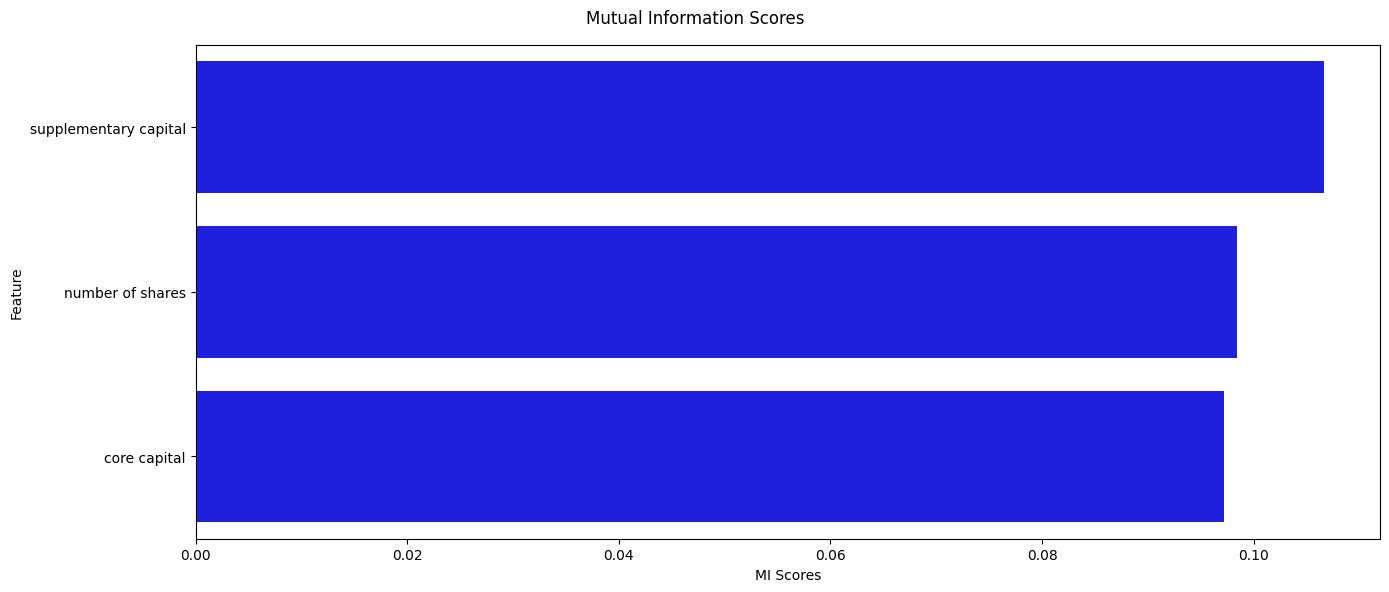

In [33]:
bench_mi = mi_scores(X_train_proc, y_clf_train)

In [39]:
high_bench_mi = bench_mi[bench_mi['MI Scores'] > .05]['MI Scores'].index.tolist()

xgb_simple(
    X_train_proc.filter(high_bench_mi), y_clf_train,
    X_val_proc.filter(high_bench_mi), y_clf_val,
    'Benchmark model'
)

Model's precision for class Yes on training set: 0.7385


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1520,351,303
Maybe,309,1565,301
Yes,228,241,1705



Model's precision for class Yes on validation set: 0.5371


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,171,124,89
Maybe,105,187,92
Yes,78,96,210


## New ratio variables

From the analysis of the gurus' strategies, we can conclude that the ratios used often referred to the share price (e.g. price to earnings ratio) and sometimes also to the number of shares (e.g. price to average earnings per share), EBIT, EBITDA, net earnings or sales revenues. We will try to use this knowledge to create new ratios:
- dividing the price by another indicator (*price_to_feature*),
- dividing an indicator by the number of shares (*feature_per_share*), EBIT (*feature_ebit*), EBITDA (*feature_ebitda*), net earnings (*feature_net_earnings*) and sales revenues (*feature_sales_revenues*).

Missing values will again be replaced by KNN imputer with 100 neighbours, in addition the missing indicators will be added.

The dataset thus transformed has 1179 categorical variables and 1328 numerical variables. The new dataset provided three new variables with MI scores above 0.05: **supplementary_capital_per_share**, **core_capital_per_share** and **company_value_per_share**. Precision score increased on both the training set (to 0.7755) and the validation set (to 0.5446).

In [40]:
def ratio_features(source_set):
    """Function creating ratio variables"""

    invalid_cols = [
        *source_set.filter(regex='price').columns.tolist(),
        *source_set.filter(regex='share').columns.tolist(),
        *source_set.filter(regex='ebit').columns.tolist(),
        *source_set.filter(regex='ebitda').columns.tolist(),
        *source_set.filter(regex='net_earnings').columns.tolist(),
        *source_set.filter(regex='sales_revenues').columns.tolist(),
        *source_set.select_dtypes('category').columns.tolist()
    ]
    invalid_cols = set(invalid_cols)

    temp_set = {}

    for col in source_set:
        if col not in invalid_cols:
            temp_set['price_to_' + col] = source_set.price / source_set[col]
            temp_set[col + '_per_share'] = source_set[col] / source_set.number_of_shares
            temp_set[col + '_ebit'] = source_set[col] / source_set.ebit
            temp_set[col + '_ebitda'] = source_set[col] / source_set.ebitda
            temp_set[col + '_net_earnings'] = source_set[col] / source_set.net_earnings
            temp_set[col + '_sales_revenues'] = source_set[col] / source_set.sales_revenues

    temp_set = pd.concat([source_set, pd.DataFrame(temp_set, index=source_set.index)], axis=1)
    temp_set = temp_set.loc[:, ~temp_set.columns.duplicated()]

    # Replace inf with nan
    temp_set = temp_set.replace([np.inf, -np.inf], np.nan)

    return temp_set

X_train_ratio = ratio_features(X_train_proc)
X_val_ratio = ratio_features(X_val_proc)

# Scaling numerical data
train_means = X_train_ratio.drop(cat_cols_updated, axis=1, errors='ignore').mean()
train_stds = X_train_ratio.drop(cat_cols_updated, axis=1, errors='ignore').std()

X_train_scaled = (
    X_train_ratio.drop(cat_cols_updated, axis=1, errors='ignore') - train_means) / train_stds
X_val_scaled = (
    X_val_ratio.drop(cat_cols_updated, axis=1, errors='ignore') - train_means) / train_stds

X_train_scaled = pd.concat([X_train_ratio.filter(cat_cols_updated), X_train_scaled], axis=1)
X_val_scaled = pd.concat([X_val_ratio.filter(cat_cols_updated), X_val_scaled], axis=1)

# Imputing
imp_pipe = ColumnTransformer(
    transformers=[
        (
            'knn_imputer',
            KNNImputer(n_neighbors=100, weights='distance', add_indicator=True),
            X_train_scaled.drop(cat_cols_updated, axis=1, errors='ignore').columns.to_list()
        )
    ],
    remainder='passthrough'
)

X_train_ratio = pd.DataFrame(
    imp_pipe.fit_transform(X_train_scaled),
    index=X_train_scaled.index,
    columns=[col_name.split('__', 1)[1] for col_name in imp_pipe.get_feature_names_out()]
)
X_val_ratio = pd.DataFrame(
    imp_pipe.transform(X_val_scaled),
    index=X_val_scaled.index,
    columns=[col_name.split('__', 1)[1] for col_name in imp_pipe.get_feature_names_out()]
)

cat_cols_updated = list(
    set(cat_cols_updated + X_train_ratio.filter(regex='missingindicator').columns.tolist())
)

# Scale data back
X_train_ratio = pd.concat(
    [
        X_train_ratio.filter(cat_cols_updated),
        X_train_ratio.drop(cat_cols_updated, axis=1, errors='ignore') * train_stds + train_means
    ],
    axis=1
)
X_val_ratio = pd.concat(
    [
        X_val_ratio.filter(cat_cols_updated),
        X_val_ratio.drop(cat_cols_updated, axis=1, errors='ignore') * train_stds + train_means
    ],
    axis=1
)

# Converting dummy cols to category
dummy_cols = [
    'dividend_1Y', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y', 'pos_net_earnings_3Y',
    'pos_net_earnings_2Y', 'pos_net_earnings_1Y'
] + X_train_ratio.filter(
    regex='country'
).columns.tolist() + X_train_ratio.filter(
    regex='industry'
).columns.tolist() + X_train_ratio.filter(regex='missingindicator').columns.tolist()

X_train_ratio[dummy_cols] = X_train_ratio[dummy_cols].astype('category')
X_val_ratio[dummy_cols] = X_val_ratio[dummy_cols].astype('category')

# Converting 'continuous' to ordered category
for col in ['continuous_dividend', 'continuous_price_growth']:
    X_train_ratio[col] = pd.Categorical(
        X_train_ratio[col],
        categories=set(X_train_ratio[col]),
        ordered=True
    )
    X_val_ratio[col] = pd.Categorical(
        X_val_ratio[col],
        categories=set(X_val_ratio[col]),
        ordered=True
    )

# Removing some wrong features like roce_ebit 
# (ROCE is core capital * EBIT, so ROCE / EBIT is simply core capital)
X_train_ratio.drop(
    ['capitalization_per_share', 'price_to_capitalization', 'roce_ebit'], axis=1, inplace=True
)
X_val_ratio.drop(
    ['capitalization_per_share', 'price_to_capitalization', 'roce_ebit'], axis=1, inplace=True
)

# Change numeric features back to float type
num_cols = [
    col for col in X_train_ratio.columns if col not in 
    dummy_cols + ['continuous_dividend', 'continuous_price_growth']
]
X_train_ratio[num_cols] = X_train_ratio[num_cols].astype('float64')
X_val_ratio[num_cols] = X_val_ratio[num_cols].astype('float64')

In [41]:
X_train_ratio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6523 entries, 4295 to 17583
Columns: 2507 entries, missingindicator_short_term_investment_yy_sales_revenues to long_term_liabilities_net_working_capital_sales_revenues
dtypes: category(1179), float64(1328)
memory usage: 73.9 MB


Number of features with MI score greater than 0: 1694
Number of features with MI score greater than 0.05: 6

Features with top MI scores:
                                 MI Scores
supplementary_capital               0.1100
number_of_shares                    0.1073
core_capital                        0.1038
supplementary_capital_per_share     0.0936
core_capital_per_share              0.0863
company_value_per_share             0.0525


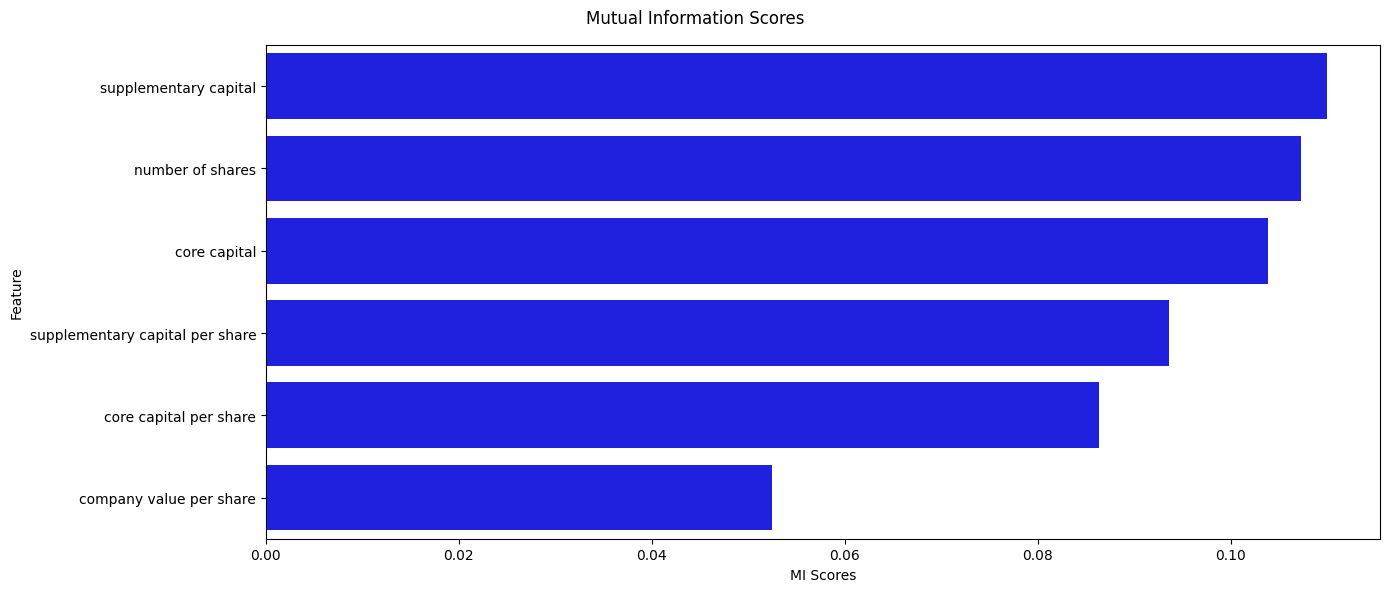

In [42]:
ratio_mi = mi_scores(X_train_ratio, y_clf_train)

In [98]:
high_ratio_mi = ratio_mi[ratio_mi['MI Scores'] > .05]['MI Scores'].index.tolist()

xgb_simple(
    X_train_ratio.filter(high_ratio_mi), y_clf_train,
    X_val_ratio.filter(high_ratio_mi), y_clf_val,
    'New ratios'
)

Model's precision for class Yes on training set: 0.7836


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1664,282,228
Maybe,233,1659,283
Yes,167,157,1850



Model's precision for class Yes on validation set: 0.5319


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,167,124,93
Maybe,90,189,105
Yes,70,89,225


## Piotroski F-Score

The Piotroski F-Score is a discrete score ranging from zero to nine that reflects the 9 criteria used to determine the strength of a company's financial position. These criteria are:
- positive ROA,
- positive cash flow from operational activities,
- increase in ROA y/y,
- cash flow from operational activities higher than total assets,
- decrease in long-term debt y/y,
- increase in current liquidity y/y,
- number of shares less than or the same as a year earlier,
- increase in sales profit margin y/y,
- increase in total assets turnover y/y.

The higher the score, the better the company's rating. We will add 9 binary variables taking 1 if the company meets the criterion at a given time (0 otherwise) and an ordinal variable describing the Piotroski F-Score. However, these variables achieved a relatively low MI score (for Piotroski F-Score: 0.0026). At the same time, the MI score for the **company_value_per_share** variable fell below 0.05, which also worsened the precision score.

In [44]:
def piotroski_f_score(source_set):
    """Function adding Piotroski F-Score"""

    temp_set = {
        'piotroski_I':pd.Categorical(np.where(source_set.roa > 0, 1, 0)),
        'piotroski_II':pd.Categorical(
            np.where(source_set.cash_flows_from_operational_activities > 0, 1, 0)
        ),
        'piotroski_III':pd.Categorical(np.where(source_set.roa_yy > 0, 1, 0)),
        'piotroski_IV':pd.Categorical(
            np.where(
                source_set.cash_flows_from_operational_activities > source_set.total_assets, 1, 0
            )
        ),
        'piotroski_V':pd.Categorical(np.where(source_set.long_term_debt_yy < 0, 1, 0)),
        'piotroski_VI':pd.Categorical(np.where(source_set.current_liquidity_yy > 0, 1, 0)),
        'piotroski_VII':pd.Categorical(np.where(source_set.number_of_shares_yy <= 0, 1, 0)),
        'piotroski_VIII':pd.Categorical(np.where(source_set.sales_earnings_margin_yy > 0, 1, 0)),
        'piotroski_IX':pd.Categorical(np.where(source_set.total_assets_turnover_yy > 0, 1, 0))
    }

    temp_set = pd.DataFrame(temp_set, index=source_set.index)
    temp_set['piotroski_f_score'] = pd.Categorical(
        temp_set[temp_set.columns.tolist()].sum(axis=1),
        ordered=True,
        categories=range(10)
    )

    temp_set = pd.concat([source_set, temp_set], axis=1)

    return temp_set

X_train_pfs = piotroski_f_score(X_train_ratio)
X_val_pfs = piotroski_f_score(X_val_ratio)

Number of features with MI score greater than 0: 1713
Number of features with MI score greater than 0.05: 5

Features with top MI scores:
                                 MI Scores
core_capital                        0.1095
supplementary_capital               0.1073
number_of_shares                    0.1005
supplementary_capital_per_share     0.0915
core_capital_per_share              0.0798


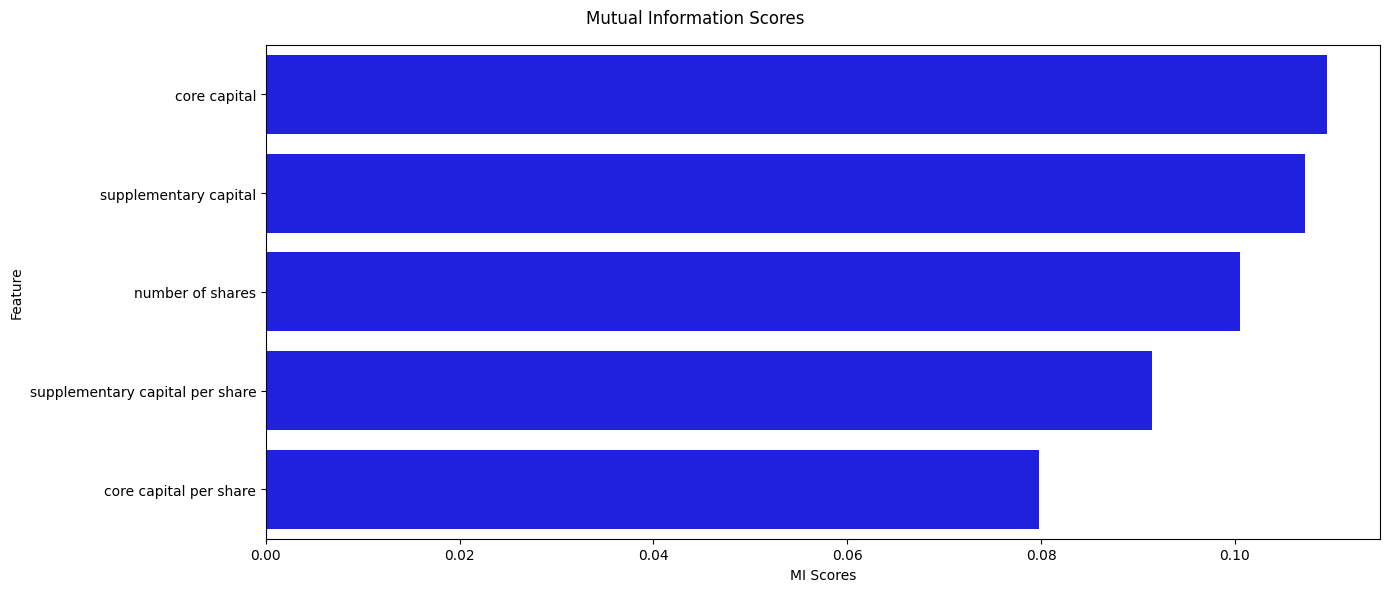

In [45]:
pfs_mi = mi_scores(X_train_pfs, y_clf_train)

In [46]:
print('MI scores of Piotroski F-Score variables')
pfs_mi.filter(regex='piotroski', axis=0)

MI scores of Piotroski F-Score variables


,MI Scores
piotroski_V,0.0090
piotroski_VII,0.0048
piotroski_IV,0.0046
piotroski_f_score,0.0026
piotroski_I,0.0018
piotroski_VIII,0.0014
piotroski_II,0.0000
piotroski_III,0.0000
piotroski_IX,0.0000
piotroski_VI,0.0000


In [47]:
high_pfs_mi = pfs_mi[pfs_mi['MI Scores'] > .05].index.tolist()

xgb_simple(
    X_train_pfs.filter(high_pfs_mi), y_clf_train,
    X_val_pfs.filter(high_pfs_mi), y_clf_val,
    'Piotroski F-Score'
)

Model's precision for class Yes on training set: 0.7542


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1559,349,266
Maybe,254,1616,305
Yes,207,215,1752



Model's precision for class Yes on validation set: 0.5395


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,170,123,91
Maybe,84,193,107
Yes,62,90,232


## Altman Z-Score

Another indicator is the Altman Z-Score, which assesses a company's financial health and its risk of bankruptcy. It is calculated according to the formula:

*Altman Z-Score = 1.2 * X_1 + 1.4 * X_2 + 3.3 * X_3 + 0.6 * X_4 + X_5*

where:
- X_1: share of working capital in total assets,
- X_2: (net earnings - value of dividends paid) / total assets,
- X_3: EBIT / total assets,
- X_4: capitalization / total liabilities,
- X_5: sales revenues / total assets.

The higher the value of the index, the better the company's performance. As with the Piotroski F-Score, the new variables have a relatively low MI score (for Altman Z-Score: 0.0053). The list of variables with high MI scores has not changed.

In [48]:
def altman_z_score(source_set):
    """Function adding Altman Z-Score"""

    temp_set = {
        'altman_I':source_set.share_of_working_capital_in_assets,
        'altman_II':(source_set.net_earnings - source_set.dividend_val) / source_set.total_assets,
        'altman_III':source_set.ebit / source_set.total_assets,
        'altman_IV':source_set.capitalization / source_set.total_liabilities,
        'altman_V':source_set.sales_revenues / source_set.total_assets
    }

    temp_set = pd.DataFrame(temp_set, index=source_set.index)
    temp_set['altman_z_score'] = (
        1.2 * temp_set.altman_I + 1.4 * temp_set.altman_II + 3.3 * temp_set.altman_III
        + .6 * temp_set.altman_IV + temp_set.altman_V
    )

    temp_set = pd.concat([source_set, temp_set], axis=1)

    return temp_set

X_train_azs = altman_z_score(X_train_pfs)
X_val_azs = altman_z_score(X_val_pfs)

Number of features with MI score greater than 0: 1717
Number of features with MI score greater than 0.05: 5

Features with top MI scores:
                                 MI Scores
core_capital                        0.1069
number_of_shares                    0.1048
supplementary_capital               0.1044
supplementary_capital_per_share     0.0933
core_capital_per_share              0.0805


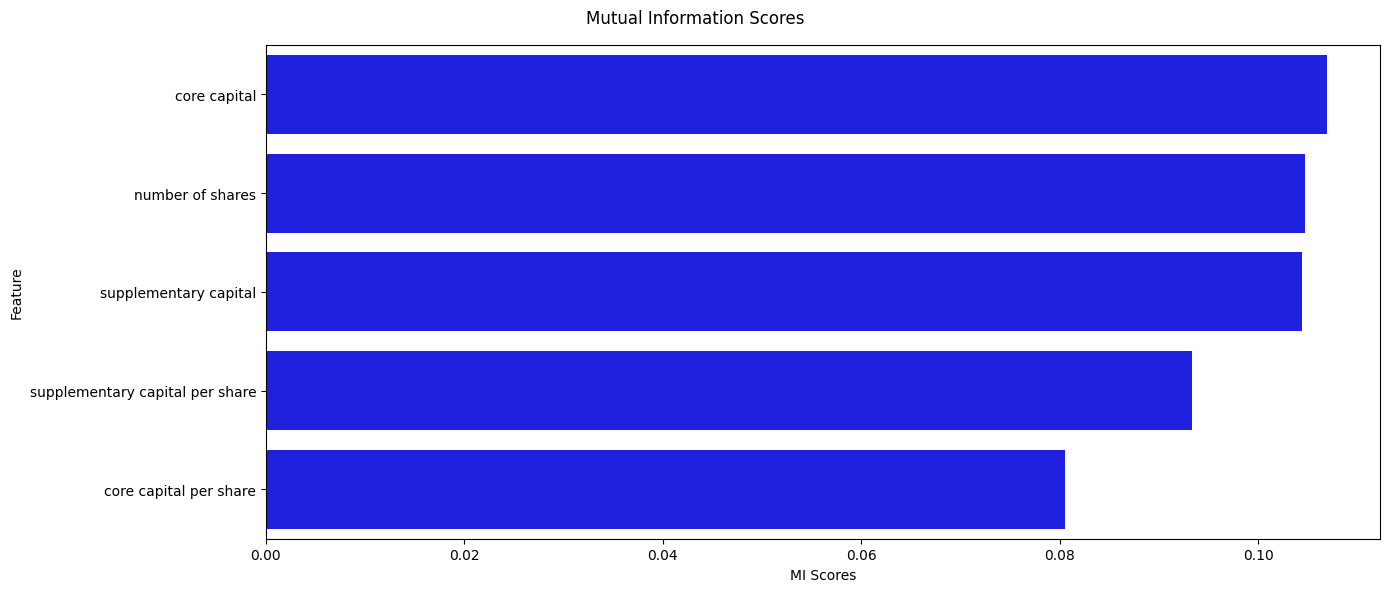

In [49]:
azs_mi = mi_scores(X_train_azs, y_clf_train)

In [50]:
print('MI scores of Altman Z-Score variables')
azs_mi.filter(regex='altman', axis=0)

MI scores of Altman Z-Score variables


,MI Scores
altman_IV,0.0142
altman_V,0.0066
altman_z_score,0.0053
altman_I,0.0036
altman_II,0.0033
altman_III,0.0000


In [51]:
high_azs_mi = azs_mi[azs_mi['MI Scores'] > .05].index.tolist()

xgb_simple(
    X_train_azs.filter(high_azs_mi), y_clf_train,
    X_val_azs.filter(high_azs_mi), y_clf_val,
    'Altman Z-Score'
)

Model's precision for class Yes on training set: 0.7542


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1559,349,266
Maybe,254,1616,305
Yes,207,215,1752



Model's precision for class Yes on validation set: 0.5395


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,170,123,91
Maybe,84,193,107
Yes,62,90,232


## Average value & mode per country and industry

Although the variables **country** and **industry** have been encoded, we will restore them for a moment to calculate the average value of each numeric variable and the most frequent value of each categorical variable. The new dataset has 3567 categorical and 4002 numerical features. The list of variables with the highest MI score has not changed, as well as the results of the model.

In [52]:
def grouping_country_industry(source_set, base_set):
    """Function adding average value & mode per country and industry"""

    temp_set = {}

    for col in source_set:
        if source_set[col].dtype in ['float64']:
            temp_set['avg_' + col + '_per_country'] = source_set.groupby(
                base_set.country)[col].transform('mean')
            temp_set['avg_' + col + '_per_industry'] = source_set.groupby(
                base_set.industry)[col].transform('mean')
        else:
            temp_set['mode_' + col + '_per_country'] = pd.Categorical(
                source_set.groupby(base_set.country)[col].transform(lambda x: x.mode()[0]),
                ordered=True
            )
            temp_set['mode_' + col + '_per_industry'] = pd.Categorical(
                source_set.groupby(base_set.industry)[col].transform(lambda x: x.mode()[0]),
                ordered=True
            )

    temp_set = pd.DataFrame(temp_set, index=source_set.index)

    temp_set = pd.concat([source_set, temp_set], axis=1)

    return temp_set

X_train_group = grouping_country_industry(X_train_azs, X_train)
X_val_group = grouping_country_industry(X_val_azs, X_val)

In [53]:
X_train_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6523 entries, 4295 to 17583
Columns: 7569 entries, missingindicator_short_term_investment_yy_sales_revenues to avg_altman_z_score_per_industry
dtypes: category(3567), float64(4002)
memory usage: 222.1 MB


Number of features with MI score greater than 0: 5067
Number of features with MI score greater than 0.05: 5

Features with top MI scores:
                                 MI Scores
core_capital                        0.1081
supplementary_capital               0.1029
number_of_shares                    0.0987
supplementary_capital_per_share     0.0936
core_capital_per_share              0.0678


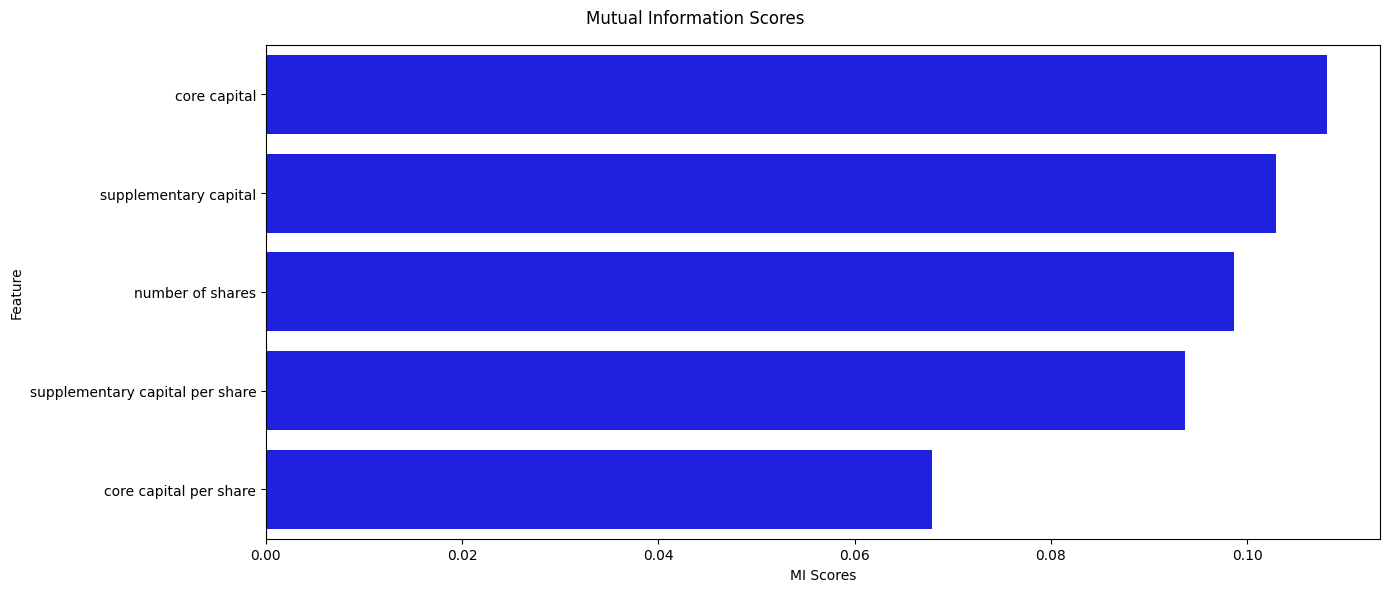

In [54]:
group_mi = mi_scores(X_train_group, y_clf_train)

In [55]:
high_group_mi = group_mi[group_mi['MI Scores'] > .05].index.tolist()

xgb_simple(
    X_train_group.filter(high_group_mi), y_clf_train,
    X_val_group.filter(high_group_mi), y_clf_val,
    'Group transformations'
)

Model's precision for class Yes on training set: 0.7542


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1559,349,266
Maybe,254,1616,305
Yes,207,215,1752



Model's precision for class Yes on validation set: 0.5395


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,170,123,91
Maybe,84,193,107
Yes,62,90,232


## Outliers

The training set includes 3989 variables with outliers (i.e., observations whose absolute value is lower than first quartile minus 1.5 * interquartile range (IQR) or greater than third quartile plus 1.5 * IQR). The largest number of such observations is in the **avg_ii_degree_of_coverage_yy_ebitda_per_industry** variable - 2913, which accounts for 45% of the set. Removing observations with outliers would significantly reduce their number.

The alternative is capping outliers. The list of variables with the highest MI score has not changed, however, the precision score on the training and validation sets has slightly improved.

In [56]:
# Outliers in the training set
quartile_1 = X_train_group.select_dtypes('float64').quantile(.25)
quartile_3 = X_train_group.select_dtypes('float64').quantile(.75)
iqr = quartile_3 - quartile_1

lower_lim = quartile_1 - 1.5 * iqr
upper_lim =  quartile_3 + 1.5 * iqr

outlier_cols = {
    col:sum(X_train_group[col] < lower_lim[col]) + sum(X_train_group[col] > upper_lim[col])
    for col in X_train_group.select_dtypes('float64')
}
outlier_cols = {col:out_num for col, out_num in outlier_cols.items() if out_num > 0}
print(f'Number of features with outliers: {len(outlier_cols)}')
print('Top 10 features with the highest number of outliers:')
sorted(outlier_cols.items(), key=lambda x:x[1], reverse=True)[:10]

Number of features with outliers: 3992
Top 10 features with the highest number of outliers:


[('avg_ii_degree_of_coverage_yy_ebitda_per_industry', 2913),
 ('avg_equity_debt_ebit_per_industry', 2757),
 ('avg_long_term_liabilities_net_working_capital_ebit_per_industry', 2753),
 ('avg_i_degree_of_coverage_sales_revenues_per_industry', 2723),
 ('avg_result_of_extraordinary_events_yy_sales_revenues_per_industry', 2678),
 ('avg_coverage_of_costs_with_working_capital_sales_revenues_per_industry',
  2676),
 ('avg_i_degree_of_coverage_yy_net_earnings_per_industry', 2662),
 ('avg_stock_rotation_net_earnings_per_industry', 2637),
 ('avg_assets_rotation_yy_sales_revenues_per_industry', 2623),
 ('avg_other_fixed_assets_yy_ebit_per_industry', 2603)]

In [57]:
# Capping outliers
X_train_cap = X_train_group.copy()
X_val_cap = X_val_group.copy()

for col in X_train_cap.select_dtypes('float64'):
    X_train_cap.loc[(X_train_cap[col] < lower_lim[col]), col] = lower_lim[col]
    X_train_cap.loc[(X_train_cap[col] > upper_lim[col]), col] = upper_lim[col]

Number of features with MI score greater than 0: 4771
Number of features with MI score greater than 0.05: 5

Features with top MI scores:
                                 MI Scores
supplementary_capital               0.0969
core_capital                        0.0959
number_of_shares                    0.0822
supplementary_capital_per_share     0.0815
core_capital_per_share              0.0548


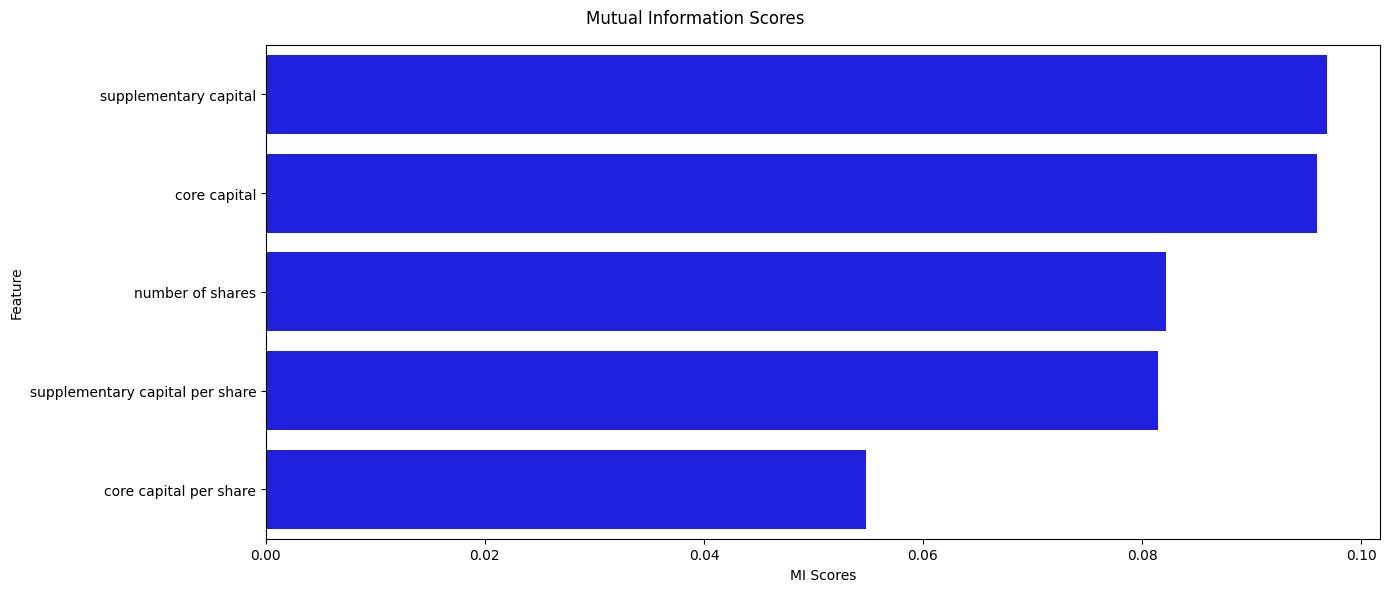

In [58]:
capped_mi = mi_scores(X_train_cap, y_clf_train)

In [59]:
high_capped_mi = capped_mi[capped_mi['MI Scores'] > .05].index.tolist()

xgb_simple(
    X_train_cap.filter(high_capped_mi), y_clf_train,
    X_val_cap.filter(high_capped_mi), y_clf_val,
    'Capped outliers'
)

Model's precision for class Yes on training set: 0.7623


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1569,349,256
Maybe,254,1641,280
Yes,198,257,1719



Model's precision for class Yes on validation set: 0.5573


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,173,129,82
Maybe,92,200,92
Yes,67,98,219


## Yeo–Johnson transformation

The 3666 variables in the training set had a skewness of less than -1 or greater than 1. A natural solution for features having right or left skewed distribution would be a transformation using a logarithm or exponential function, however, in the analyzed dataset, many values are not positive. Instead, we will use the Yeo-Johnson transformation, which has no such restrictions.

Of the variables obtained in this way, seven achieved MI scores above 0.05: **pt_number_of_shares**, **pt_supplementary_capital**, **pt_core_capital**, **pt_supplementary_capital_per_share**, **pt_core_capital_per_share**, **pt_company_value_per_share** and **pt_company_value**. As you can see, all of them were created on the basis of variables that already had a relatively high MI score. While adding these variables to the model yields results that are better on the training set, on the validation set the model's metrics are generally worse than in the benchmark model.

In [86]:
print('Number of numerical features with skewness lower than -1 or greater than 1: '\
    f'{sum(abs(X_train_group.skew(numeric_only=True)) > 1)}')
print(f'Number of highly right-skewed features: {sum(X_train_group.skew(numeric_only=True) > 1)}')
print(f'Number of highly left-skewed features: {sum(X_train_group.skew(numeric_only=True) < -1)}')

Number of numerical features with skewness lower than -1 or greater than 1: 3666
Number of highly right-skewed features: 2323
Number of highly left-skewed features: 1343


In [87]:
# Transformation
X_train_pt = pd.concat(
    [
        X_train_group,
        pd.DataFrame(
            power_transform(X_train_group.select_dtypes('float64')),
            columns=['pt_' + col for col in X_train_group.select_dtypes('float64').columns],
            index=X_train_group.index
        )
    ],
    axis=1
)

X_val_pt = pd.concat(
    [
        X_val_group,
        pd.DataFrame(
            power_transform(X_val_group.select_dtypes('float64')),
            columns=['pt_' + col for col in X_val_group.select_dtypes('float64').columns],
            index=X_val_group.index
        )
    ],
    axis=1
)

Number of features with MI score greater than 0: 8413
Number of features with MI score greater than 0.05: 12

Features with top MI scores:
                                    MI Scores
pt_number_of_shares                    0.1094
supplementary_capital                  0.1060
pt_supplementary_capital               0.1047
number_of_shares                       0.1041
core_capital                           0.1040
pt_core_capital                        0.1031
pt_supplementary_capital_per_share     0.0951
supplementary_capital_per_share        0.0941
pt_core_capital_per_share              0.0810
core_capital_per_share                 0.0802
pt_company_value_per_share             0.0564
pt_company_value                       0.0508


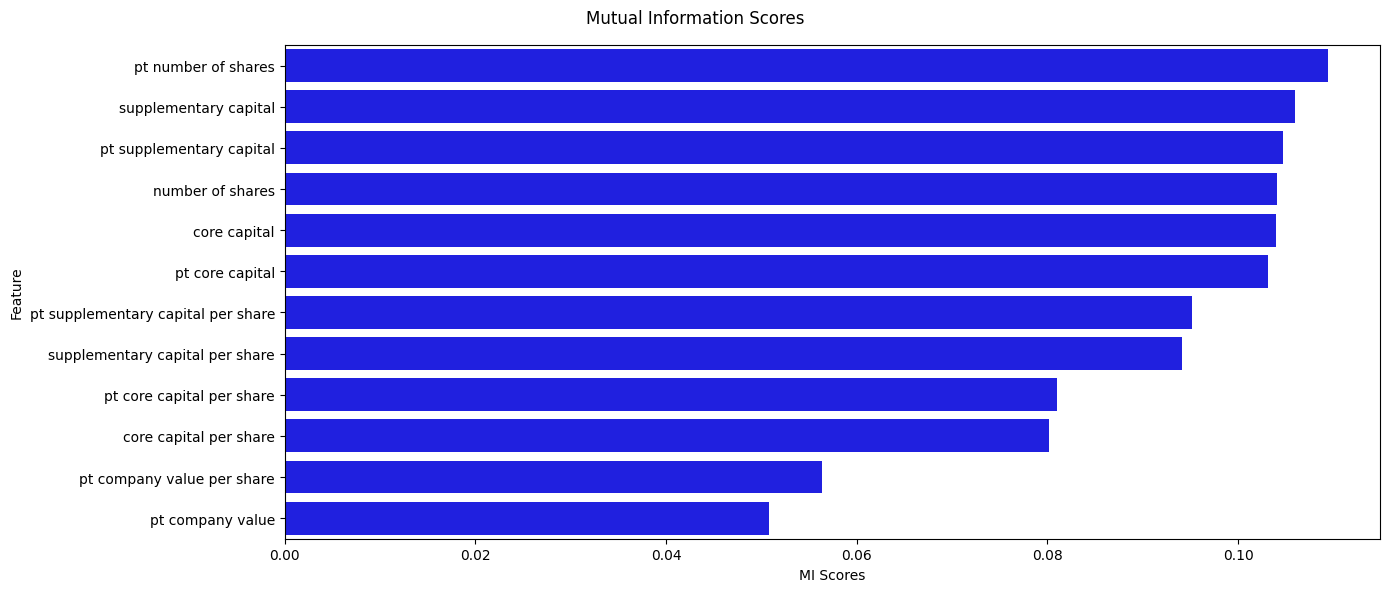

In [ ]:
pt_mi = mi_scores(X_train_pt, y_clf_train)

In [63]:
high_pt_mi = pt_mi[pt_mi['MI Scores'] > .05].index.tolist()

xgb_simple(
    X_train_pt.filter(high_pt_mi), y_clf_train,
    X_val_pt.filter(high_pt_mi), y_clf_val,
    'Power transformation'
)

Model's precision for class Yes on training set: 0.7853


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1657,290,227
Maybe,225,1679,271
Yes,162,191,1821



Model's precision for class Yes on validation set: 0.4709


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,161,119,104
Maybe,136,143,105
Yes,112,86,186


Alternatively, we can limit ourselves to only the transformed variables, however, this approach further degrades the model's performance on the validation set.

In [65]:
high_pt_mi = pt_mi.filter(
    [
        'pt_number_of_shares', 'pt_supplementary_capital', 'pt_core_capital',
        'pt_supplementary_capital_per_share', 'pt_core_capital_per_share',
        'pt_company_value_per_share', 'pt_company_value'  
    ],
    axis=0
).index.tolist()

xgb_simple(
    X_train_pt.filter(high_pt_mi), y_clf_train,
    X_val_pt.filter(high_pt_mi), y_clf_val,
    'Power transformation'
)

Model's precision for class Yes on training set: 0.7922


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1695,259,220
Maybe,255,1667,253
Yes,178,193,1803



Model's precision for class Yes on validation set: 0.3615


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,189,104,91
Maybe,196,113,75
Yes,215,75,94


# Models' evaluation

For models using variables with MI greater than 0.05, the only significant improvement in model quality occurred when new ratio variables were added and when outliers were capped. Subsequent transformations did not add variables with relatively high MI - the exception being the version of the sets with variables created using the Yeo-Johnson transformation, which significantly worsened the performance of the models on the validation set.

Though the gurus' strategies generally used at most a few indicators - and we intend to replicate this scheme - however, 5-6 variables may be too few. Comparing the precision score of the models on the dataset after adding ratio variables and the dataset with capped outliers, we can see that the latter has an advantage only if we will choose variables with an MI score higher than 0.04. Adding the **price** variable in the model based on the dataset with only ratio variables significantly improves its score. So in the end we will choose the following variables:
- **company_value**
- **company_value_per_share**
- **core_capital**
- **core_capital_per_share**
- **long_term_investment_per_share**
- **number_of_shares**
- **price**
- **supplementary_capital**
- **supplementary_capital_per_share**

In [125]:
results = {
    'Training precision (ratio set)':[],
    'Validation precision (ratio set)':[],
    'Number of features (ratio set)':[],
    'Training precision (capped set)':[],
    'Validation precision (capped set)':[],
    'Number of features (capped set)':[]
}

for i in range(-50, -25, 5):
    high_ratio_mi = ratio_mi[ratio_mi['MI Scores'] > i / -1000]['MI Scores'].index.tolist()
    high_capped_mi = capped_mi[capped_mi['MI Scores'] > i / -1000]['MI Scores'].index.tolist()

    train_ratio_precision, val_ratio_precision = xgb_results(
        X_train_ratio.filter(high_ratio_mi), y_clf_train,
        X_val_ratio.filter(high_ratio_mi), y_clf_val
    )

    train_capped_precision, val_capped_precision = xgb_results(
        X_train_cap.filter(high_capped_mi), y_clf_train,
        X_val_cap.filter(high_capped_mi), y_clf_val
    )

    results['Training precision (ratio set)'].append(train_ratio_precision)
    results['Validation precision (ratio set)'].append(val_ratio_precision)
    results['Number of features (ratio set)'].append(len(high_ratio_mi))
    results['Training precision (capped set)'].append(train_capped_precision)
    results['Validation precision (capped set)'].append(val_capped_precision)
    results['Number of features (capped set)'].append(len(high_capped_mi))

In [128]:
results_df = pd.DataFrame(results, index=[i / -1000 for i in range(-50, -25, 5)])
results_df

,Training precision (ratio set),Validation precision (ratio set),Number of features (ratio set),Training precision (capped set),Validation precision (capped set),Number of features (capped set)
0.0500,0.7755,0.5446,6,0.7623,0.5573,5
0.0450,0.7836,0.5319,7,0.7623,0.5573,5
0.0400,0.8395,0.5268,8,0.8337,0.5414,6
0.0350,0.9028,0.5985,9,0.8337,0.5414,6
0.0300,0.9646,0.6085,19,0.9670,0.5639,17


In [132]:
ratio_mi[ratio_mi['MI Scores'] > .035]

,MI Scores
supplementary_capital,0.1100
number_of_shares,0.1073
core_capital,0.1038
supplementary_capital_per_share,0.0936
core_capital_per_share,0.0863
company_value_per_share,0.0525
company_value,0.0485
long_term_investment_per_share,0.0442
price,0.0393


In [134]:
# List of chosen features
final_features = [
    'company_value', 'company_value_per_share', 'core_capital', 'core_capital_per_share',
    'long_term_investment_per_share', 'number_of_shares', 'price', 'supplementary_capital',
    'supplementary_capital_per_share'
]

# One step back

Before we move on to model tuning, let's take a step back - by limiting ourselves to only a selected seven variables, will we be able to modify them enough to achieve better model performance?

The starting point will be the imputation of missing values. We performed it twice - at the very beginning of the analysis, and then after the new ratios were created. Many of the divisors had values equal to 0, resulting in missing values in the ratios. This time our only divisor is the number of shares, which has only values greater than zero, so the imputation will occur only once and will only apply to the **company_value**, **core_capital**,  **supplementary_capital** and **long_term_investment** variables (they have 691, 315, 327 and 298 observations with missing values, respectively). In addition to addressing the missing values, we will also check the outliers and try to deal with the distribution of the selected variables (in each case it is right-skewed and leptokurtic).

In [135]:
print('Basic statistics of final features:')
X_train.filter(final_features + ['long_term_investment']).describe()

Basic statistics of final features:


,company_value,core_capital,number_of_shares,price,supplementary_capital,long_term_investment
count,5832.0000,6208.0000,6523.0000,6523.0000,6196.0000,6225.0000
mean,112307.5039,162389.9335,88311257.3155,52.6261,308837.3993,184483.8021
std,2131095.0546,1081605.7304,573677819.2909,358.3608,1419884.4800,1419929.1189
min,0.0000,8.0000,52631.0000,0.0200,-1803797.0000,0.0000
25%,0.0000,2470.0000,6259634.0000,3.2800,16942.7500,5.0000
50%,0.0000,9499.0000,14900000.0000,9.4500,55891.0000,2256.0000
75%,9261.0000,32289.2500,41551852.0000,26.0000,146674.0000,23097.0000
max,105344774.0000,19165000.0000,17340641302.0000,14330.0000,27131265.0000,42224823.0000


In [137]:
print('Number of observations with missing values in final features:')
X_train.filter(final_features + ['long_term_investment']).isna().sum()

Number of observations with missing values in final features:


company_value            691
core_capital             315
number_of_shares           0
price                      0
supplementary_capital    327
long_term_investment     298
dtype: int64

In [140]:
print('Skewness of final features:')
X_train.filter(final_features + ['long_term_investment']).skew()

Skewness of final features:


company_value           43.7618
core_capital            12.7456
number_of_shares        23.2250
price                   23.7319
supplementary_capital   10.5395
long_term_investment    17.0120
dtype: float64

In [141]:
print('Kurtosis of final features:')
X_train.filter(final_features + ['long_term_investment']).kurtosis()

Kurtosis of final features:


company_value           2054.4384
core_capital             189.6661
number_of_shares         616.8223
price                    692.4090
supplementary_capital    130.1869
long_term_investment     351.1320
dtype: float64

Let's first prepare a benchmark model based on the training set before any changes. The precision score on the training set is 0.905, while on the validation set is 0.6065.

In [143]:
# Benchmark dataset
X_train_bench = X_train.filter(final_features)
X_val_bench = X_val.filter(final_features)

# Additional features
X_train_bench[
    'company_value_per_share'
] = X_train.company_value / X_train.number_of_shares
X_train_bench[
    'core_capital_per_share'
] = X_train.core_capital / X_train.number_of_shares
X_train_bench[
    'long_term_investment_per_share'
] = X_train.long_term_investment / X_train.number_of_shares
X_train_bench[
    'supplementary_capital_per_share'
] = X_train.supplementary_capital / X_train.number_of_shares

X_val_bench[
    'company_value_per_share'
] = X_val.company_value / X_val.number_of_shares
X_val_bench[
    'core_capital_per_share'
] = X_val.core_capital / X_val.number_of_shares
X_val_bench[
    'long_term_investment_per_share'
] = X_val.long_term_investment / X_val.number_of_shares
X_val_bench[
    'supplementary_capital_per_share'
] = X_val.supplementary_capital / X_val.number_of_shares

X_train_bench = X_train_bench.replace([np.inf, -np.inf], np.nan)
X_val_bench = X_val_bench.replace([np.inf, -np.inf], np.nan)

xgb_simple(
    X_train_bench, y_clf_train,
    X_val_bench, y_clf_val,
    'New benchmark model'
)

Model's precision for class Yes on training set: 0.905


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1913,177,84
Maybe,144,1902,129
Yes,52,93,2029



Model's precision for class Yes on validation set: 0.6065


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,202,113,69
Maybe,99,184,101
Yes,52,70,262


## Imputation

Removing the missing values improved the precision score on the training set, but worsened it on the validation set (to 0.6023).

In [147]:
# Drop NAs
X_train_drop = X_train_bench.filter(final_features).dropna()
X_val_drop = X_val_bench.filter(final_features).dropna()

y_clf_train_drop = y_clf_train[y_clf_train.index.isin(X_train_drop.index)]
y_clf_val_drop = y_clf_val[y_clf_val.index.isin(X_val_drop.index)]

xgb_simple(
    X_train_drop, y_clf_train_drop,
    X_val_drop, y_clf_val_drop,
    'Drop NAs'
)

Model's precision for class Yes on training set: 0.9097


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1720,105,68
Maybe,96,1701,110
Yes,42,67,1812



Model's precision for class Yes on validation set: 0.6023


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,181,90,58
Maybe,85,165,87
Yes,48,70,227


Replacing missing values with averages significantly worsened precision scores on both the training and validation sets. However, using medians further worsened the precision score on the training set, but significantly improved it on the validation set (to 0.609).

In [148]:
# Fill NAs with mean
X_train_mean = X_train.filter(final_features + ['long_term_investment'])
X_val_mean = X_val.filter(final_features + ['long_term_investment'])

mean_imputer = SimpleImputer(strategy='mean')
col_names = X_train_mean.columns.tolist()

X_train_mean = pd.DataFrame(
    mean_imputer.fit_transform(X_train_mean),
    index=X_train_mean.index,
    columns=col_names
)
X_val_mean = pd.DataFrame(
    mean_imputer.transform(X_val_mean),
    index=X_val_mean.index,
    columns=col_names
)

X_train_mean[
    'company_value_per_share'
] = X_train_mean.company_value / X_train_mean.number_of_shares
X_train_mean['core_capital_per_share'] = X_train_mean.core_capital / X_train_mean.number_of_shares
X_train_mean[
    'long_term_investment_per_share'
] = X_train_mean.long_term_investment / X_train_mean.number_of_shares
X_train_mean[
    'supplementary_capital_per_share'
] = X_train_mean.supplementary_capital / X_train_mean.number_of_shares

X_val_mean[
    'company_value_per_share'
] = X_val_mean.company_value / X_val_mean.number_of_shares
X_val_mean['core_capital_per_share'] = X_val_mean.core_capital / X_val_mean.number_of_shares
X_val_mean[
    'long_term_investment_per_share'
] = X_val_mean.long_term_investment / X_val_mean.number_of_shares
X_val_mean[
    'supplementary_capital_per_share'
] = X_val_mean.supplementary_capital / X_val_mean.number_of_shares

X_train_mean.drop(['long_term_investment'], axis=1, inplace=True)
X_val_mean.drop(['long_term_investment'], axis=1, inplace=True)

xgb_simple(
    X_train_mean, y_clf_train,
    X_val_mean, y_clf_val,
    'NAs filled with mean'
)

Model's precision for class Yes on training set: 0.8979


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1924,157,93
Maybe,142,1895,138
Yes,55,89,2030



Model's precision for class Yes on validation set: 0.5776


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,197,115,72
Maybe,94,185,105
Yes,60,82,242


In [149]:
# Fill NAs with median
X_train_median = X_train.filter(final_features + ['long_term_investment'])
X_val_median = X_val.filter(final_features + ['long_term_investment'])

median_imputer = SimpleImputer(strategy='median')
col_names = X_train_median.columns.tolist()

X_train_median = pd.DataFrame(
    median_imputer.fit_transform(X_train_median),
    index=X_train_median.index,
    columns=col_names
)
X_val_median = pd.DataFrame(
    median_imputer.transform(X_val_median),
    index=X_val_median.index,
    columns=col_names
)

X_train_median[
    'company_value_per_share'
] = X_train_median.company_value / X_train_median.number_of_shares
X_train_median['core_capital_per_share'] = X_train_median.core_capital / X_train_median.number_of_shares
X_train_median[
    'long_term_investment_per_share'
] = X_train_median.long_term_investment / X_train_median.number_of_shares
X_train_median[
    'supplementary_capital_per_share'
] = X_train_median.supplementary_capital / X_train_median.number_of_shares

X_val_median[
    'company_value_per_share'
] = X_val_median.company_value / X_val_median.number_of_shares
X_val_median['core_capital_per_share'] = X_val_median.core_capital / X_val_median.number_of_shares
X_val_median[
    'long_term_investment_per_share'
] = X_val_median.long_term_investment / X_val_median.number_of_shares
X_val_median[
    'supplementary_capital_per_share'
] = X_val_median.supplementary_capital / X_val_median.number_of_shares

X_train_median.drop(['long_term_investment'], axis=1, inplace=True)
X_val_median.drop(['long_term_investment'], axis=1, inplace=True)

xgb_simple(
    X_train_median, y_clf_train,
    X_val_median, y_clf_val,
    'NAs filled with median'
)

Model's precision for class Yes on training set: 0.8959


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1918,170,86
Maybe,133,1894,148
Yes,74,87,2013



Model's precision for class Yes on validation set: 0.609


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,198,115,71
Maybe,96,194,94
Yes,54,73,257


Recall from an earlier analysis that we used KNN imputer with 100 neighbors. It turns out that the precision score reach the highest value on the validation set for imputations with 335 neighbors. Such an imputation gives better results on the validation set than the benchmark model, so it will be used in further analysis.

In [152]:
# Categorical data
cat_cols = [
    'dividend_1Y', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y', 'pos_net_earnings_3Y',
    'pos_net_earnings_2Y', 'pos_net_earnings_1Y', 'country', 'industry', 'continuous_dividend',
    'continuous_price_growth'
]

# Scaling numerical data
train_means = X_train.drop(cat_cols, axis=1, errors='ignore').mean()
train_stds = X_train.drop(cat_cols, axis=1, errors='ignore').std()

X_train_scaled = (X_train.drop(cat_cols, axis=1, errors='ignore') - train_means) / train_stds
X_val_scaled = (X_val.drop(cat_cols, axis=1, errors='ignore') - train_means) / train_stds

X_train_scaled = pd.concat([X_train.filter(cat_cols), X_train_scaled], axis=1)
X_val_scaled = pd.concat([X_val.filter(cat_cols), X_val_scaled], axis=1)

# Results dict
knn_results_dict = {
    'Training Precision':[],
    'Validation Precision':[]
}

for n in range(5, 1005, 5):
    # Imputation
    imputer = ColumnTransformer(
        transformers=[
            (
                'imputer_num',
                KNNImputer(n_neighbors=n, weights='distance'),
                ['company_value', 'core_capital', 'supplementary_capital', 'long_term_investment']
            )
        ],
        remainder='passthrough'
    )

    # Impute NAs
    X_train_knn = pd.DataFrame(
        imputer.fit_transform(X_train_scaled),
        index=X_train_scaled.index,
        columns=[col_name.split('__', 1)[1] for col_name in imputer.get_feature_names_out()]
    )
    X_val_knn = pd.DataFrame(
        imputer.transform(X_val_scaled),
        index=X_val_scaled.index,
        columns=[col_name.split('__', 1)[1] for col_name in imputer.get_feature_names_out()]
    )

    # Scale data back
    X_train_knn = pd.concat(
        [
            X_train_knn.filter(cat_cols),
            X_train_knn.drop(cat_cols, axis=1, errors='ignore') * train_stds + train_means
        ],
        axis=1
    )
    X_val_knn = pd.concat(
        [
            X_val_knn.filter(cat_cols),
            X_val_knn.drop(cat_cols, axis=1, errors='ignore') * train_stds + train_means
        ],
        axis=1
    )

    # Add ratios
    for x_set in [X_train_knn, X_val_knn]:
        x_set['company_value_per_share'] = x_set.company_value / x_set.number_of_shares
        x_set['core_capital_per_share'] = x_set.core_capital / x_set.number_of_shares
        x_set[
            'long_term_investment_per_share'
        ] = x_set.long_term_investment / x_set.number_of_shares
        x_set[
            'supplementary_capital_per_share'
        ] = x_set.supplementary_capital / x_set.number_of_shares

    # Filter sets
    X_train_knn = X_train_knn.filter(final_features)
    X_val_knn = X_val_knn.filter(final_features)

    # Change numeric features back to float type
    X_train_knn = X_train_knn.astype('float64')
    X_val_knn = X_val_knn.astype('float64')
    
    # XGB
    train_precision, val_precision = xgb_results(
        X_train_knn, y_clf_train,
        X_val_knn, y_clf_val
    )

    knn_results_dict['Training Precision'].append(train_precision)
    knn_results_dict['Validation Precision'].append(val_precision)

knn_results = pd.DataFrame(knn_results_dict, index = range(5, 1005, 5))

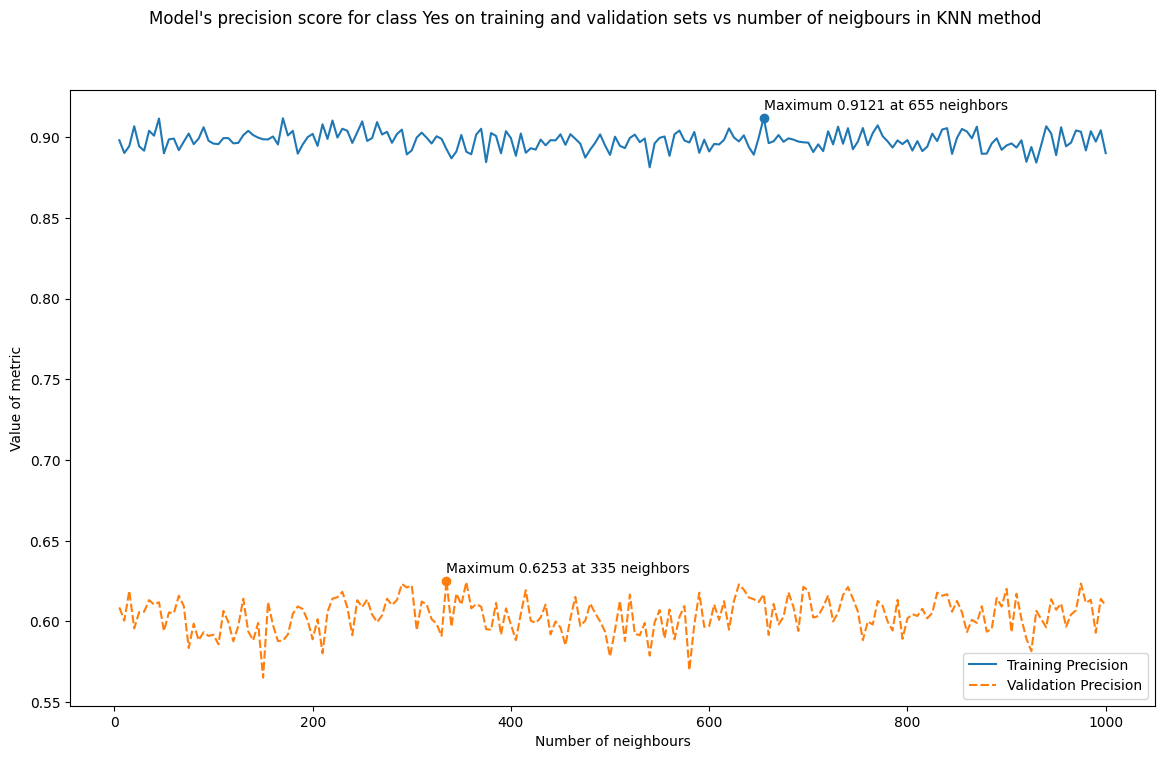

In [157]:
fig, ax = plt.subplots(figsize=(14, 8))

sns.lineplot(
    data=knn_results,
    ax=ax
)

tr_idxmax = knn_results['Training Precision'].idxmax()
tr_max = round(knn_results['Training Precision'].max(), 4)
val_idxmax = knn_results['Validation Precision'].idxmax()
val_max = round(knn_results['Validation Precision'].max(), 4)

ax.scatter(tr_idxmax, tr_max)
ax.scatter(val_idxmax, val_max)

ax.text(tr_idxmax, tr_max+.005, f'Maximum {tr_max} at {tr_idxmax} neighbors')
ax.text(val_idxmax, val_max+.005, f'Maximum {val_max} at {val_idxmax} neighbors')

ax.set_xlabel('Number of neighbours')
ax.set_ylabel('Value of metric')

plt.suptitle(
    'Model\'s precision score for class Yes on training and validation sets '\
        'vs number of neigbours in KNN method'
)

plt.tight_layout;

In [164]:
print('Precision scores for 335 neighbors:')
print(knn_results.iloc[66, :])
print('\nPrecision scores for 655 neighbors:')
print(knn_results.iloc[130, :])

Precision scores for 335 neighbors:
Training Precision     0.8927
Validation Precision   0.6253
Name: 335, dtype: float64

Precision scores for 655 neighbors:
Training Precision     0.9121
Validation Precision   0.6168
Name: 655, dtype: float64


In [165]:
# Imputation
imputer = ColumnTransformer(
    transformers=[
        (
            'imputer_num',
            KNNImputer(n_neighbors=335, weights='distance'),
            ['company_value', 'core_capital', 'supplementary_capital', 'long_term_investment']
        )
    ],
    remainder='passthrough'
)

# Impute NAs
X_train_knn = pd.DataFrame(
    imputer.fit_transform(X_train_scaled),
    index=X_train_scaled.index,
    columns=[col_name.split('__', 1)[1] for col_name in imputer.get_feature_names_out()]
)
X_val_knn = pd.DataFrame(
    imputer.transform(X_val_scaled),
    index=X_val_scaled.index,
    columns=[col_name.split('__', 1)[1] for col_name in imputer.get_feature_names_out()]
)

# Scale data back
X_train_knn = pd.concat(
    [
        X_train_knn.filter(cat_cols),
        X_train_knn.drop(cat_cols, axis=1, errors='ignore') * train_stds + train_means
    ],
    axis=1
)
X_val_knn = pd.concat(
    [
        X_val_knn.filter(cat_cols),
        X_val_knn.drop(cat_cols, axis=1, errors='ignore') * train_stds + train_means
    ],
    axis=1
)

# Add ratios
for x_set in [X_train_knn, X_val_knn]:
    x_set['company_value_per_share'] = x_set.company_value / x_set.number_of_shares
    x_set['core_capital_per_share'] = x_set.core_capital / x_set.number_of_shares
    x_set[
        'long_term_investment_per_share'
    ] = x_set.long_term_investment / x_set.number_of_shares
    x_set[
        'supplementary_capital_per_share'
    ] = x_set.supplementary_capital / x_set.number_of_shares

# Filter sets
X_train_knn = X_train_knn.filter(final_features)
X_val_knn = X_val_knn.filter(final_features)

# Change numeric features back to float type
X_train_knn = X_train_knn.astype('float64')
X_val_knn = X_val_knn.astype('float64')

xgb_simple(
    X_train_knn, y_clf_train,
    X_val_knn, y_clf_val,
    'KNN imputation with 335 neighbors'
)

Model's precision for class Yes on training set: 0.8927


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1936,149,89
Maybe,144,1878,153
Yes,63,99,2012



Model's precision for class Yes on validation set: 0.6253


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,206,115,63
Maybe,106,184,94
Yes,45,77,262


## Outliers

In the training set obtained in this way, each of the variables has outliers - the largest number in **company_value**. In total, there are 3261 observations in the entire training set, which we can consider outliers - about 50% of the set.

In [166]:
# Outliers in the training set
quartile_1 = X_train_knn.quantile(.25)
quartile_3 = X_train_knn.quantile(.75)
iqr = quartile_3 - quartile_1

lower_lim = quartile_1 - 1.5 * iqr
upper_lim =  quartile_3 + 1.5 * iqr

outlier_cols = {
    col:sum(X_train_knn[col] < lower_lim[col]) + sum(X_train_knn[col] > upper_lim[col])
    for col in X_train_knn
}
outlier_cols = {col:out_num for col, out_num in outlier_cols.items() if out_num > 0}

X_train_ok = X_train_knn[(X_train_knn > lower_lim) & (X_train_knn < upper_lim)].dropna()

print(f'Number of observations with outliers in any feature: {len(X_train_knn) - len(X_train_ok)}')
print('Number of outliers in each feature:')
sorted(outlier_cols.items(), key=lambda x:x[1], reverse=True)

Number of observations with outliers in any feature: 3261
Number of outliers in each feature:


[('company_value', 1092),
 ('company_value_per_share', 1046),
 ('core_capital', 1011),
 ('core_capital_per_share', 1005),
 ('long_term_investment_per_share', 914),
 ('price', 856),
 ('number_of_shares', 808),
 ('supplementary_capital', 695),
 ('supplementary_capital_per_share', 686)]

Interestingly, neither the removal nor the capping of outliers resulted in any improvement in the model. Similarly, replacing outliers with missing values and then filling them with the mean / median or imputing them using the KNN method does not improve the model's performance. Outliers will thus remain in the dataset.

In [168]:
X_train_drop_outliers = X_train_knn[X_train_knn.index.isin(X_train_ok.index)]

y_clf_train_drop_outliers = y_clf_train[y_clf_train.index.isin(X_train_drop_outliers.index)]

xgb_simple(
    X_train_drop_outliers, y_clf_train_drop_outliers,
    X_val_knn, y_clf_val,
    'Outliers dropped'
)

Model's precision for class Yes on training set: 0.9644


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1004,28,13
Maybe,11,957,23
Yes,13,30,1183



Model's precision for class Yes on validation set: 0.5783


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,226,95,63
Maybe,174,141,69
Yes,125,78,181


In [169]:
X_train_cap_outliers = X_train_knn.copy()
X_val_cap_outliers = X_val_knn.copy()

# Adding cap
for data_set in [X_train_cap_outliers, X_val_cap_outliers]:
    for col in data_set:
        data_set.loc[(data_set[col] < lower_lim[col]), col] = lower_lim[col]
        data_set.loc[(data_set[col] > upper_lim[col]), col] = upper_lim[col]

xgb_simple(
    X_train_cap_outliers, y_clf_train,
    X_val_cap_outliers, y_clf_val,
    'Outliers capped'
)

Model's precision for class Yes on training set: 0.9217


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1936,176,62
Maybe,128,1938,109
Yes,67,94,2013



Model's precision for class Yes on validation set: 0.6121


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,192,122,70
Maybe,104,184,96
Yes,50,72,262


In [170]:
X_train_outliers_na = X_train_knn.copy()
X_val_outliers_na = X_val_knn.copy()

# Replacing outliers with NAs
for data_set in [X_train_outliers_na, X_val_outliers_na]:
    for col in data_set:
        data_set.loc[(data_set[col] < lower_lim[col]), col] = np.nan
        data_set.loc[(data_set[col] > upper_lim[col]), col] = np.nan

In [171]:
# Fill NAs with mean

mean_imputer = SimpleImputer(strategy='mean')
col_names = X_train_outliers_na.columns.tolist()

X_train_outliers_mean = pd.DataFrame(
    mean_imputer.fit_transform(X_train_outliers_na),
    index=X_train_outliers_na.index,
    columns=col_names
)
X_val_outliers_mean = pd.DataFrame(
    mean_imputer.transform(X_val_outliers_na),
    index=X_val_outliers_na.index,
    columns=col_names
)

xgb_simple(
    X_train_outliers_mean, y_clf_train,
    X_val_outliers_mean, y_clf_val,
    'Outliers replaced by mean'
)

Model's precision for class Yes on training set: 0.8907


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1889,201,84
Maybe,163,1855,157
Yes,90,121,1963



Model's precision for class Yes on validation set: 0.5718


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,197,112,75
Maybe,106,180,98
Yes,69,84,231


In [172]:
# Fill NAs with median

median_imputer = SimpleImputer(strategy='median')
col_names = X_train_outliers_na.columns.tolist()

X_train_outliers_median = pd.DataFrame(
    median_imputer.fit_transform(X_train_outliers_na),
    index=X_train_outliers_na.index,
    columns=col_names
)
X_val_outliers_median = pd.DataFrame(
    median_imputer.transform(X_val_outliers_na),
    index=X_val_outliers_na.index,
    columns=col_names
)

xgb_simple(
    X_train_outliers_median, y_clf_train,
    X_val_outliers_median, y_clf_val,
    'Outliers replaced by median'
)

Model's precision for class Yes on training set: 0.8849


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1873,211,90
Maybe,161,1849,165
Yes,88,127,1959



Model's precision for class Yes on validation set: 0.5694


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,197,107,80
Maybe,89,195,100
Yes,61,85,238


In [173]:
# Categorical data
cat_cols = [
    'dividend_1Y', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y', 'pos_net_earnings_3Y',
    'pos_net_earnings_2Y', 'pos_net_earnings_1Y', 'country', 'industry', 'continuous_dividend',
    'continuous_price_growth'
]

# Add data to old dataset
X_train_outliers_knn = pd.concat(
    [
        X_train.drop(
            final_features, axis=1, errors='ignore')[X_train.index.isin(X_train_outliers_na.index)],
        X_train_outliers_na
    ],
    axis=1
)

X_val_outliers_knn = pd.concat(
    [
        X_val.drop(
            final_features, axis=1, errors='ignore')[X_val.index.isin(X_val_outliers_na.index)],
        X_val_outliers_na
    ],
    axis=1
)

# Scaling numerical data
train_means = X_train_outliers_knn.drop(cat_cols, axis=1, errors='ignore').mean()
train_stds = X_val_outliers_knn.drop(cat_cols, axis=1, errors='ignore').std()

X_train_scaled = (
    X_train_outliers_knn.drop(cat_cols, axis=1, errors='ignore') - train_means) / train_stds
X_val_scaled = (
    X_val_outliers_knn.drop(cat_cols, axis=1, errors='ignore') - train_means) / train_stds

X_train_scaled = pd.concat(
    [
        X_train.filter(cat_cols)[X_train.index.isin(X_train_outliers_na.index)],
        X_train_scaled
    ],
    axis=1
)
X_val_scaled = pd.concat(
    [
        X_val.filter(cat_cols)[X_val.index.isin(X_val_outliers_na.index)],
        X_val_scaled
    ],
    axis=1
)

# Imputation
imputer = ColumnTransformer(
    transformers=[
        (
            'imputer_num',
            KNNImputer(n_neighbors=335, weights='distance'),
            final_features
        )
    ],
    remainder='passthrough'
)

# Impute NAs
X_train_outliers_knn = pd.DataFrame(
    imputer.fit_transform(X_train_scaled),
    index=X_train_scaled.index,
    columns=[col_name.split('__', 1)[1] for col_name in imputer.get_feature_names_out()]
)
X_val_outliers_knn = pd.DataFrame(
    imputer.transform(X_val_scaled),
    index=X_val_scaled.index,
    columns=[col_name.split('__', 1)[1] for col_name in imputer.get_feature_names_out()]
)

# Scale data back
X_train_outliers_knn = X_train_outliers_knn.drop(
    cat_cols, axis=1, errors='ignore') * train_stds + train_means
X_val_outliers_knn = X_val_outliers_knn.drop(
    cat_cols, axis=1, errors='ignore') * train_stds + train_means

# Filter sets
X_train_outliers_knn = X_train_outliers_knn.filter(final_features)
X_val_outliers_knn = X_val_outliers_knn.filter(final_features)

# Change numeric features back to float type
X_train_outliers_knn = X_train_outliers_knn.astype('float64')
X_val_outliers_knn = X_val_outliers_knn.astype('float64')

xgb_simple(
    X_train_outliers_knn, y_clf_train,
    X_val_outliers_knn, y_clf_val,
    'Outliers imputed by KNN'
)

Model's precision for class Yes on training set: 0.8909


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1916,169,89
Maybe,141,1874,160
Yes,65,77,2032



Model's precision for class Yes on validation set: 0.5925


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,199,114,71
Maybe,106,186,92
Yes,65,82,237


## Yeo-Johnson transformation

After imputation of missing valus, all variables have a right-skewed and leptokurtic distribution. Only the variables **supplementary_capital** and **supplementary_capital_per_share** have negative values.

In [174]:
print('Basic statistics of final features (after imputing NAs):')
X_train_knn.describe()

Basic statistics of final features (after imputing NAs):


,company_value,company_value_per_share,core_capital,core_capital_per_share,long_term_investment_per_share,number_of_shares,price,supplementary_capital,supplementary_capital_per_share
count,6523.0000,6523.0000,6523.0000,6523.0000,6523.0000,6523.0000,6523.0000,6523.0000,6523.0000
mean,109521.6058,0.0029,162603.4160,0.0042,0.0048,88311257.3155,52.6261,313253.1004,0.0156
std,2015826.3675,0.0318,1055497.1761,0.0455,0.0676,573677819.2909,358.3608,1387825.6613,0.1051
min,0.0000,0.0000,8.0000,0.0000,0.0000,52631.0000,0.0200,-1803797.0000,-0.0122
25%,0.0000,0.0000,2580.5000,0.0001,0.0000,6259634.0000,3.2800,18064.0000,0.0013
50%,1.0730,0.0000,10511.0000,0.0010,0.0002,14900000.0000,9.4500,60330.0000,0.0039
75%,17880.8900,0.0009,42628.0000,0.0020,0.0014,41551852.0000,26.0000,176058.5000,0.0098
max,105344774.0000,2.1339,19165000.0000,3.0854,3.5052,17340641302.0000,14330.0000,27131265.0000,5.8680


In [175]:
print('Skewness of final features (after imputing NAs):')
X_train_knn.skew()

Skewness of final features (after imputing NAs):


company_value                     46.2310
company_value_per_share           53.1235
core_capital                      13.0521
core_capital_per_share            54.7680
long_term_investment_per_share    43.5537
number_of_shares                  23.2250
price                             23.7319
supplementary_capital             10.7194
supplementary_capital_per_share   34.4329
dtype: float64

In [176]:
print('Kurtosis of final features (after imputing NAs):')
X_train_knn.kurtosis()

Kurtosis of final features (after imputing NAs):


company_value                     2294.6771
company_value_per_share           3322.1380
core_capital                       199.1677
core_capital_per_share            3464.9843
long_term_investment_per_share    2115.5197
number_of_shares                   616.8223
price                              692.4090
supplementary_capital              135.4807
supplementary_capital_per_share   1639.6086
dtype: float64

Again, we will use the Yeo-Johnson transformation - however, the variables transformed in this way reduce the quality of the model somewhat.

In [177]:
# Power transformation
pt = PowerTransformer()
X_train_pt = pd.DataFrame(
    pt.fit_transform(X_train_knn),
    columns=['pt_' + col for col in X_train_knn.columns],
    index=X_train_knn.index
)
X_val_pt  = pd.DataFrame(
    pt.transform(X_val_knn),
    columns=['pt_' + col for col in X_val_knn.columns],
    index=X_val_knn.index
)

xgb_simple(
    X_train_pt, y_clf_train,
    X_val_pt, y_clf_val,
    'Yeo-Johnson transformation'
)

Model's precision for class Yes on training set: 0.8984


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1956,142,76
Maybe,137,1886,152
Yes,56,102,2016



Model's precision for class Yes on validation set: 0.6


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,209,105,70
Maybe,95,191,98
Yes,60,72,252


## Final dataset

The only transformation that improved the quality of the model was the removal of observations with missing values. The following function summarizes the entire dataset creation process so far:
- loading the source data,
- preprocessing and splitting into training, validation and test sets,
- imputing missing values in selected variables,
- adding **company_value_per_share**, **core_capital_per_share**, **long_term_investment_per_share** and **supplementary_capital_per_share** variables,
- scaling the data.

In [3]:
# Final dataset

def final_transformation():
    """Final transformation of datasets"""

    # Dataset loading (the newest full dataset)
    dataset = pd.read_csv(
        max(
            glob.glob(os.getcwd().replace('analysis', '') + 'data\\full_datasets\\*.csv'),
            key = os.path.getctime
        ),
        index_col=False,
        low_memory=False
    )

    # List of chosen features
    final_features = [
        'company_value', 'company_value_per_share', 'core_capital', 'core_capital_per_share',
        'long_term_investment_per_share', 'number_of_shares', 'price', 'supplementary_capital',
        'supplementary_capital_per_share'
    ]

    # Categorical columns
    cat_cols = [
        'dividend_1Y', 'continuous_dividend', 'pos_net_earnings_5Y', 'pos_net_earnings_4Y',
        'pos_net_earnings_3Y', 'pos_net_earnings_2Y', 'pos_net_earnings_1Y',
        'continuous_price_growth'
    ]

    def preprocessor(temp_dataset, drop_subset, treshold):
        """All initial transformations"""
        # temp_dataset = copy of the original dataset
        # non_num_columns = non-numeric columns
        # div_columns = dividend columns
        # drop_subset = target and auxilliary columns to be removed from X sets
        # treshold = % of observations with missing values

        # Fixing bug resulting from dividing the features
        # In some values dot is replaced by comma and whole column gets wrong data type
        temp_dataset.replace(',', '.', regex=True, inplace=True)
        subset = temp_dataset.columns[~temp_dataset.columns.isin([
            'quarter', 'company_code', 'best_price_dynamics_in_q',
            'price_dynamics_y_in_q', 'country', 'industry'
        ])]
        temp_dataset[subset] = temp_dataset[subset].astype(float)
        temp_dataset = temp_dataset.replace([np.inf, -np.inf], np.nan)

        # Fill NAs in dividend data with 0 (NA here means that dividend most probably wasn't paid)
        # The same for positive net earnings in previous years
        for col in cat_cols:
            temp_dataset[col] = temp_dataset[col].fillna(0)

        # There is a wrong price reported by company FMG in Q4 2018. The company reported price at
        # 0.15 - however, in neighbouring quarters it was 30.93 and 28. Checking this information
        # on another stock exchange website (stooq.pl) confirms that this is an incorrect value
        # - this company was listed on the stock exchange only once in Q4 2018, but with a price of
        # 29, which is a better approximation of the real price.
        idx = temp_dataset.loc[
            np.where(
                (temp_dataset.company_code == 'FMG')
                & (temp_dataset.quarter == '2018/Q4')
            )
        ].index[0]
        temp_dataset.loc[idx, 'price'] = 29
        temp_dataset.loc[idx, 'best_price_dynamics_y'] = (28 - 29) / 29
        temp_dataset.loc[idx, 'price_dynamics_y'] = (9 - 29) / 29

        # Adding new features
        dynamics = {
            'adj_best_price_dynamics_y':
            81 * temp_dataset.best_price_dynamics_y / temp_dataset.inflation_yy_m,
            'adj_price_dynamics_y':81 * temp_dataset.price_dynamics_y / temp_dataset.inflation_yy_m,
            'adj_best_wig_dynamics_y':
            81 * temp_dataset.best_wig_dynamics_y / temp_dataset.inflation_yy_m,
            'adj_wig_dynamics_y':81 * temp_dataset.wig_dynamics_y / temp_dataset.inflation_yy_m,
            'final_price_dynamics':pd.Series(
                np.where(
                    81 * temp_dataset.best_price_dynamics_y / temp_dataset.inflation_yy_m > .5,
                    .5, 81 * temp_dataset.price_dynamics_y / temp_dataset.inflation_yy_m
                )
            ),
            'final_wig_dynamics':pd.Series(
                np.where(
                    81 * temp_dataset.best_wig_dynamics_y / temp_dataset.inflation_yy_m > .5,
                    .5, 81 * temp_dataset.wig_dynamics_y / temp_dataset.inflation_yy_m
                )
            ),
            'sold_in_q':pd.Series(np.where(
                81 * temp_dataset.best_price_dynamics_y / temp_dataset.inflation_yy_m > .5,
                temp_dataset.best_price_dynamics_in_q,
                temp_dataset.price_dynamics_y_in_q
            ))
        }
        dynamics = pd.DataFrame(dynamics)

        dynamics['interesting_investment'] = pd.Categorical(
            pd.Series(
                np.where(
                    dynamics.final_price_dynamics == .5,
                    'Yes', np.where(
                        dynamics.final_price_dynamics >= 0,
                        'Maybe', 'No'
                    )
                )
            ),
            categories=['No', 'Maybe', 'Yes'],
            ordered=True
        )

        temp_dataset = pd.concat(
            [temp_dataset, pd.DataFrame(dynamics, index=temp_dataset.index)],
            axis=1
        )

        # Removing variables with more than x% missing values
        temp_dataset.dropna(thresh=len(temp_dataset) * treshold, axis=1, inplace=True)

        # Down-sample majority classes
        n_samples = len(temp_dataset[temp_dataset.interesting_investment == 'Yes'])

        temp_class_no = resample(
            temp_dataset[temp_dataset.interesting_investment == 'No'],
            replace=False,
            n_samples=n_samples,
            random_state=1234
        )

        temp_class_maybe = resample(
            temp_dataset[temp_dataset.interesting_investment == 'Maybe'],
            replace=False,
            n_samples=n_samples,
            random_state=1234
        )

        temp_dataset = pd.concat([
            temp_class_no,
            temp_class_maybe,
            temp_dataset[temp_dataset.interesting_investment == 'Yes']
        ])

        # Train test split
        # Target features kept in X_set for train-validation split
        X_set = temp_dataset.copy()
        y_set = temp_dataset.filter(['interesting_investment'])

        X_train, X_test, y_train, y_test = train_test_split(
            X_set, y_set, test_size=.15, random_state=1234,
            shuffle=True, stratify=y_set.interesting_investment
        )

        # Creating X_test_set
        y_test = X_test.filter(['interesting_investment'])
        X_test.drop(drop_subset, axis=1, errors='ignore', inplace=True)

        test_set = (X_test, y_test)

        # Train validation split
        X_set = X_train.copy()
        y_set = X_train.filter(['interesting_investment'])

        X_train, X_val, y_train, y_val = train_test_split(
            X_set, y_set, test_size=.15, random_state=1234,
            shuffle=True, stratify=y_set.interesting_investment
        )

        # Creating X_train_set
        y_clf_train = X_train.filter(['interesting_investment'])
        X_train.drop(drop_subset, axis=1, errors='ignore', inplace=True)

        train_set = (X_train, y_clf_train)

        # Creating X_val_set
        y_clf_val = X_val.filter(['interesting_investment'])
        X_val.drop(drop_subset, axis=1, errors='ignore', inplace=True)

        val_set = (X_val, y_clf_val)

        return temp_dataset, train_set, val_set, test_set

    def processor(train_set, val_set, test_set):
        """Imputing NAs and adding ratios"""

        # Scaling numerical data
        train_means = train_set[0].drop(cat_cols, axis=1, errors='ignore').mean()
        train_stds = train_set[0].drop(cat_cols, axis=1, errors='ignore').std()

        X_train_scaled = (train_set[0].drop(
            cat_cols, axis=1, errors='ignore') - train_means) / train_stds
        X_val_scaled = (val_set[0].drop(
            cat_cols, axis=1, errors='ignore') - train_means) / train_stds
        X_test_scaled = (test_set[0].drop(
            cat_cols, axis=1, errors='ignore') - train_means) / train_stds

        X_train_scaled = pd.concat([train_set[0].filter(cat_cols), X_train_scaled], axis=1)
        X_val_scaled = pd.concat([val_set[0].filter(cat_cols), X_val_scaled], axis=1)
        X_test_scaled = pd.concat([test_set[0].filter(cat_cols), X_test_scaled], axis=1)

        # Imputation
        imputer = ColumnTransformer(
            transformers=[
                (
                    'imputer_num',
                    KNNImputer(n_neighbors=335, weights='distance'),
                    [
                        'company_value', 'core_capital', 'supplementary_capital',
                        'long_term_investment'
                    ]
                )
            ],
            remainder='passthrough'
        )

        # Impute NAs
        X_train_knn = pd.DataFrame(
            imputer.fit_transform(X_train_scaled),
            index=X_train_scaled.index,
            columns=[col_name.split('__', 1)[1] for col_name in imputer.get_feature_names_out()]
        )
        X_val_knn = pd.DataFrame(
            imputer.transform(X_val_scaled),
            index=X_val_scaled.index,
            columns=[col_name.split('__', 1)[1] for col_name in imputer.get_feature_names_out()]
        )
        X_test_knn = pd.DataFrame(
            imputer.transform(X_test_scaled),
            index=X_test_scaled.index,
            columns=[col_name.split('__', 1)[1] for col_name in imputer.get_feature_names_out()]
        )

        # Saving the imputer
        joblib.dump(imputer, 'transformers\\classification\\imputer')

        # Scale data back
        X_train_knn = pd.concat(
            [
                X_train_knn.filter(cat_cols),
                X_train_knn.drop(cat_cols, axis=1, errors='ignore') * train_stds + train_means
            ],
            axis=1
        )
        X_val_knn = pd.concat(
            [
                X_val_knn.filter(cat_cols),
                X_val_knn.drop(cat_cols, axis=1, errors='ignore') * train_stds + train_means
            ],
            axis=1
        )
        X_test_knn = pd.concat(
            [
                X_test_knn.filter(cat_cols),
                X_test_knn.drop(cat_cols, axis=1, errors='ignore') * train_stds + train_means
            ],
            axis=1
        )

        # Add ratios
        for x_set in [X_train_knn, X_val_knn, X_test_knn]:
            x_set['company_value_per_share'] = x_set.company_value / x_set.number_of_shares
            x_set['core_capital_per_share'] = x_set.core_capital / x_set.number_of_shares
            x_set[
                'long_term_investment_per_share'
            ] = x_set.long_term_investment / x_set.number_of_shares
            x_set[
                'supplementary_capital_per_share'
            ] = x_set.supplementary_capital / x_set.number_of_shares

        # Filter sets
        X_train_knn = X_train_knn.filter(final_features)
        X_val_knn = X_val_knn.filter(final_features)
        X_test_knn = X_test_knn.filter(final_features)

        # Change numeric features back to float type
        X_train_knn = X_train_knn.astype('float64')
        X_val_knn = X_val_knn.astype('float64')
        X_test_knn = X_test_knn.astype('float64')

        train_set = (X_train_knn, train_set[1])
        val_set = (X_val_knn, val_set[1])
        test_set = (X_test_knn, test_set[1])

        return train_set, val_set, test_set
    
    # Preprocessing - remove variables with more than 50% missing values
    dataset_preproc = dataset.copy()
    dataset_preproc, train_set, val_set, test_set = preprocessor(
        temp_dataset = dataset_preproc,
        drop_subset = [
            'best_price_dynamics_y', 'price_dynamics_y', 'best_price_dynamics_in_q',
            'price_dynamics_y_in_q', 'inflation_yy_m', 'usd_pln', 'wig', 'wig_6m',
            'best_wig_dynamics_y', 'wig_dynamics_y', 'adj_best_price_dynamics_y',
            'adj_price_dynamics_y', 'adj_best_wig_dynamics_y', 'adj_wig_dynamics_y',
            'final_wig_dynamics', 'sold_in_q', 'final_price_dynamics',
            'interesting_investment', 'avg_price_earnings', 'quarter', 'company_code'
        ] + dataset_preproc.filter(regex='rank').columns.tolist(),
        treshold = .5
    )

    # Processing - remove NAs, add ratios
    train_set, val_set, test_set = processor(train_set, val_set, test_set)
    X_train_final, y_train_final = train_set
    X_val_final, y_val_final = val_set
    X_test_final, y_test_final = test_set

    # Scaling the sets
    scaler = StandardScaler()
    X_train_final = pd.DataFrame(
        scaler.fit_transform(X_train_final),
        columns=X_train_final.columns,
        index=X_train_final.index
    )
    X_val_final = pd.DataFrame(
        scaler.transform(X_val_final),
        columns=X_val_final.columns,
        index=X_val_final.index
    )
    X_test_final = pd.DataFrame(
        scaler.transform(X_test_final),
        columns=X_test_final.columns,
        index=X_test_final.index
    )

    # Saving the scaler
    joblib.dump(scaler, 'transformers\\classification\\scaler')

    # Packing the sets
    train_set = (X_train_final, y_train_final)
    val_set = (X_val_final, y_val_final)
    test_set = (X_test_final, y_test_final)

    return dataset_preproc, train_set, val_set, test_set

dataset_preproc, train_set, val_set, test_set = final_transformation()

X_train_final, y_train_final = train_set
X_val_final, y_val_final = val_set
X_test_final, y_test_final = test_set

In [4]:
# Numerical targets, class weights, custom scorer
y_train_num = y_train_final.interesting_investment.cat.rename_categories(
    {'No':0, 'Maybe':1, 'Yes':2})
y_val_num = y_val_final.interesting_investment.cat.rename_categories({'No':0, 'Maybe':1, 'Yes':2})
y_test_num = y_test_final.interesting_investment.cat.rename_categories({'No':0, 'Maybe':1, 'Yes':2})

train_classes_weight = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train_num
)
val_classes_weight = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_val_num
)
test_classes_weight = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_test_num
)

scorer_precision = skm.make_scorer(
    skm.precision_score,
    labels=[2],
    average='macro',
    sample_weight=train_classes_weight
)

# Models' tuning

Let's move on to models and tuning their hyperparameters. Of the 26 models calculated, the highest precision score on the validation set was recorded by **RandomForestClassifier**, **ExtraTreesClassifier**, **BaggingClassifier**, **XGBClassifier** and **ExtraTreeClassifier**.

In [259]:
removed_classifiers = [
    'CategoricalNB',
    'ClassifierChain',
    'ComplementNB',
    'GradientBoostingClassifier',
    'GaussianProcessClassifier',
    'HistGradientBoostingClassifier',
    'MLPClassifier',
    'LogisticRegressionCV', 
    'MultiOutputClassifier', 
    'MultinomialNB', 
    'OneVsOneClassifier',
    'OneVsRestClassifier',
    'OutputCodeClassifier',
    'PassiveAggressiveClassifier',
    'RadiusNeighborsClassifier',
    'StackingClassifier',
    'VotingClassifier'
]

classifiers = [
    clf for clf in all_estimators()
    if (issubclass(clf[1], ClassifierMixin)) and (clf[0] not in removed_classifiers)
]
classifiers.append(('XGBClassifier', xgb.XGBClassifier))
classifiers.append(('LGBMClassifier', lgbm.LGBMClassifier))

results = {
    'Model':[],
    'Precision score':[]
}

for name, model in classifiers:
    if name in [
        'BernoulliNB', 'CalibratedClassifierCV', 'CategoricalNB', 'GaussianNB',
        'KNeighborsClassifier', 'LabelPropagation', 'LabelSpreading', 'LinearDiscriminantAnalysis',
        'NearestCentroid', 'QuadraticDiscriminantAnalysis', 'RidgeClassifierCV'
    ]:
        temp_model = model()
    elif name in ['XGBClassifier', 'LGBMClassifier']:
        temp_model = model(random_state=1234, objective='multi:softmax', num_class=3)
    else:
        temp_model = model(random_state=1234)
    temp_model.fit(X_train_final, y_train_num)
    val_pred = temp_model.predict(X_val_final)
    precision = skm.precision_score(
        y_val_num,
        val_pred,
        labels=[2],
        average='macro',
        sample_weight=val_classes_weight
    )
    results['Model'].append(name)
    results['Precision score'].append(precision)

In [264]:
results_df = pd.DataFrame(
    results['Precision score'], index=results['Model'], columns=['Precision score']
).sort_values(by=['Precision score'], ascending=False)
display(results_df)

,Precision score
RandomForestClassifier,0.6430
ExtraTreesClassifier,0.6362
BaggingClassifier,0.6047
XGBClassifier,0.6009
ExtraTreeClassifier,0.5985
KNeighborsClassifier,0.5934
LGBMClassifier,0.5752
DecisionTreeClassifier,0.5655
AdaBoostClassifier,0.4640
Perceptron,0.4450


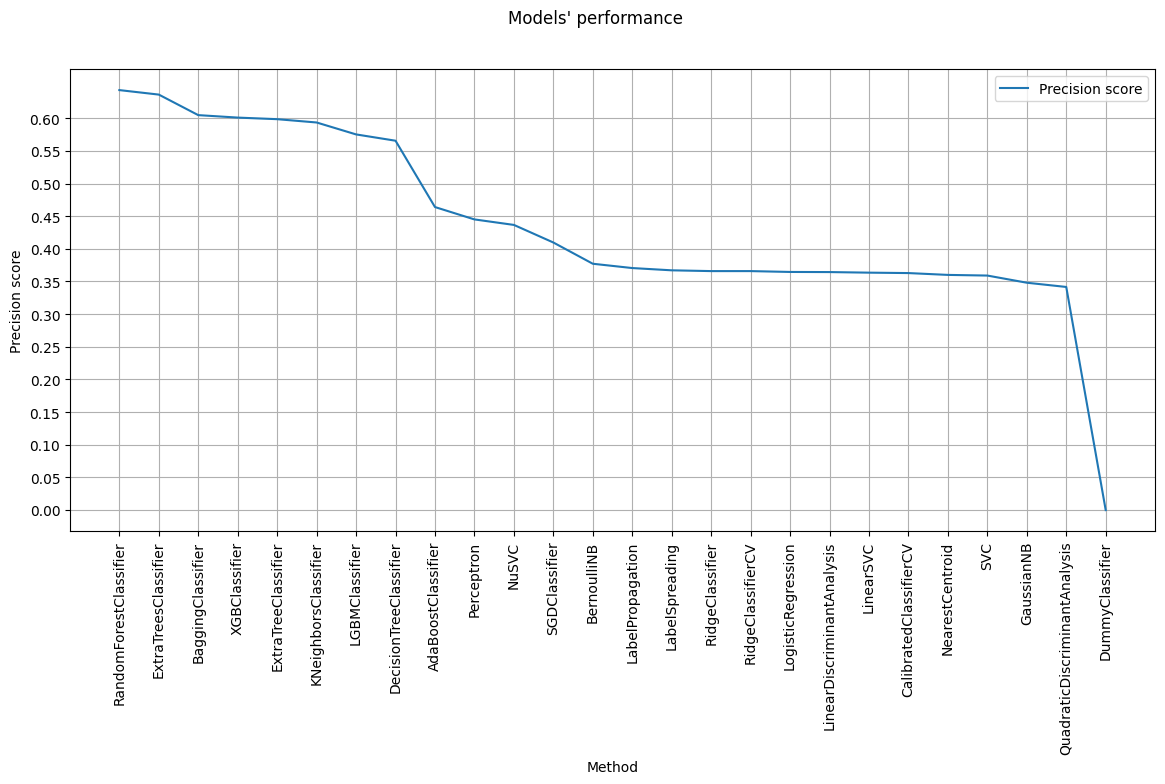

In [265]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=results_df,
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)
ax.set_yticks(np.linspace(0, .6, 13))
ax.set_xlabel('Method')
ax.set_ylabel('Precision score')
plt.suptitle('Models\' performance')

plt.grid()
plt.tight_layout;

### Random forest classifier

The best random forest achieved the highest precision score so far on the validation set (0.6538), while on the training set it achieved almost 100 percent efficiency (also in predicting the other classes). Raising the hyperparameter *max_depth* to 35 allows to further improve the precision score on the validation set slightly - to 0.6602.

In [266]:
rf_clf = ens.RandomForestClassifier(random_state=1234)

rf_params = {
    'n_estimators':[1000],
    'criterion':['entropy'],
    'max_depth':list(range(5, 55, 5)) + [None],
    'max_features':['auto'] + list(np.linspace(.1, 1, 10))
}

rf_rscv = RandomizedSearchCV(
    rf_clf, rf_params, n_iter=100, cv=5, random_state=1234, verbose=0, scoring=scorer_precision
)

rf_rscv.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

rf_rscv.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=25, max_features=0.4,
                       n_estimators=1000, random_state=1234)

In [282]:
# Best random forest classifier
rf_model = rf_rscv.best_estimator_
rf_model.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

model_results(rf_model, X_train_final, X_val_final, y_train_final, y_val_final, False)

Model's precision for class Yes on training set: 0.9991


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,2171,3,0
Maybe,0,2173,2
Yes,0,2,2172



Model's precision for class Yes on validation set: 0.6538


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,225,106,53
Maybe,88,206,90
Yes,46,68,270


In [268]:
# Saving the model
joblib.dump(rf_model, 'models\\classification\\random_forest_classifier_best')

['models\\classification\\random_forest_classifier_best']

In [284]:
rf_metrics_dict = {
    'Training Precision':[],
    'Validation Precision':[]
}

for i in range(5, 105, 5):
    rf_model_fix = ens.RandomForestClassifier(
        n_estimators=1000,
        criterion='entropy',
        max_depth=i,
		max_features=.4,
        random_state=1234
    )
    rf_model_fix.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

    train_precision, val_precision = model_results(
        rf_model_fix, X_train_final, X_val_final, y_train_final, y_val_final, True
    )

    rf_metrics_dict['Training Precision'].append(train_precision)
    rf_metrics_dict['Validation Precision'].append(val_precision)

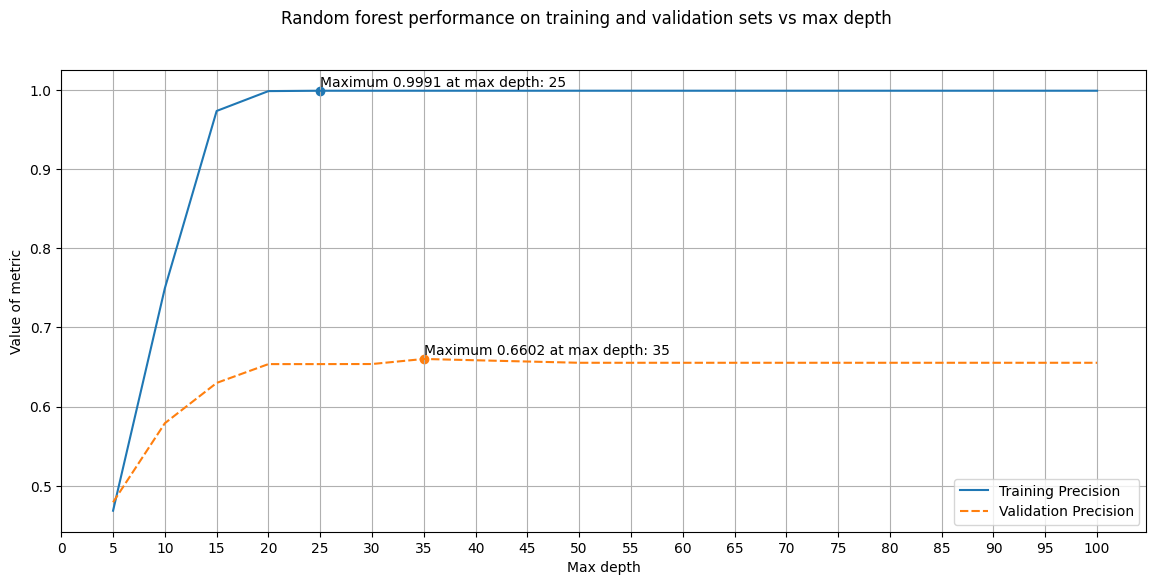

In [292]:
rf_metrics = pd.DataFrame(rf_metrics_dict, index=range(5, 105, 5))

fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=rf_metrics,
    ax=ax
)

tr_idxmax = rf_metrics['Training Precision'].idxmax()
tr_max = round(rf_metrics['Training Precision'].max(), 4)
val_idxmax = rf_metrics['Validation Precision'].idxmax()
val_max = round(rf_metrics['Validation Precision'].max(), 4)

ax.scatter(tr_idxmax, tr_max)
ax.scatter(val_idxmax, val_max)

ax.text(tr_idxmax, tr_max+.005, f'Maximum {tr_max} at max depth: {tr_idxmax}')
ax.text(val_idxmax, val_max+.005, f'Maximum {val_max} at max depth: {val_idxmax}')

ax.set_xticks(range(0, 105, 5))
ax.set_xlabel('Max depth')
ax.set_ylabel('Value of metric')
ax.grid()

plt.suptitle(
    'Random forest performance on training and validation sets vs max depth'
)

plt.tight_layout;

In [286]:
# Fixed random forest classifier

rf_model_fix = ens.RandomForestClassifier(
    n_estimators=1000,
    criterion='entropy',
    max_depth=35,
    max_features=.4,
    random_state=1234
)
rf_model_fix.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

model_results(rf_model_fix, X_train_final, X_val_final, y_train_final, y_val_final, False)

Model's precision for class Yes on training set: 0.9991


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,2171,3,0
Maybe,0,2173,2
Yes,0,2,2172



Model's precision for class Yes on validation set: 0.6602


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,227,106,51
Maybe,87,207,90
Yes,43,67,274


In [287]:
# Saving the model
joblib.dump(rf_model_fix, 'models\\classification\\random_forest_classifier_fixed')

['models\\classification\\random_forest_classifier_fixed']

### Extra trees classifier

The hyperparameters proposed by the *RandomizedSearchCV* function yielded a relatively low precision score for the *Yes* label: 0.5232 (the highest value obtained so far was 0.6602). Increasing the value of the hyperparameter *max_depth* to 70 significantly improved the precision score to 0.6351.

In [269]:
et_clf = ens.ExtraTreesClassifier(random_state=1234)

et_params = {
    'n_estimators':[1000],
    'criterion':['entropy'],
    'max_depth':list(range(5, 55, 5)) + [None],
    'max_features':['auto'] + list(np.linspace(.1, 1, 10))
}

et_rscv = RandomizedSearchCV(
    et_clf, et_params, n_iter=100, cv=5, random_state=1234, verbose=0, scoring=scorer_precision
)

et_rscv.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

et_rscv.best_estimator_

ExtraTreesClassifier(criterion='entropy', max_depth=25, max_features=0.4,
                     n_estimators=1000, random_state=1234)

In [288]:
# Best extra trees classifier
et_model = et_rscv.best_estimator_
et_model.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

model_results(et_model, X_train_final, X_val_final, y_train_final, y_val_final, False)

Model's precision for class Yes on training set: 0.691


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1723,18,433
Maybe,44,1595,536
Yes,2,6,2166



Model's precision for class Yes on validation set: 0.5232


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,191,78,115
Maybe,72,149,163
Yes,26,53,305


In [271]:
# Saving the model
joblib.dump(et_model, 'models\\classification\\extra_trees_classifier_best')

['models\\classification\\extra_trees_classifier_best']

In [289]:
et_metrics_dict = {
    'Training Precision':[],
    'Validation Precision':[]
}

for i in range(5, 105, 5):
    et_model_fix = ens.ExtraTreesClassifier(
        n_estimators=1000,
        criterion='entropy',
        max_depth=i,
        max_features=.4,
        random_state=1234
    )
    et_model_fix.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

    train_precision, val_precision = model_results(
        et_model_fix, X_train_final, X_val_final, y_train_final, y_val_final, True
    )

    et_metrics_dict['Training Precision'].append(train_precision)
    et_metrics_dict['Validation Precision'].append(val_precision)

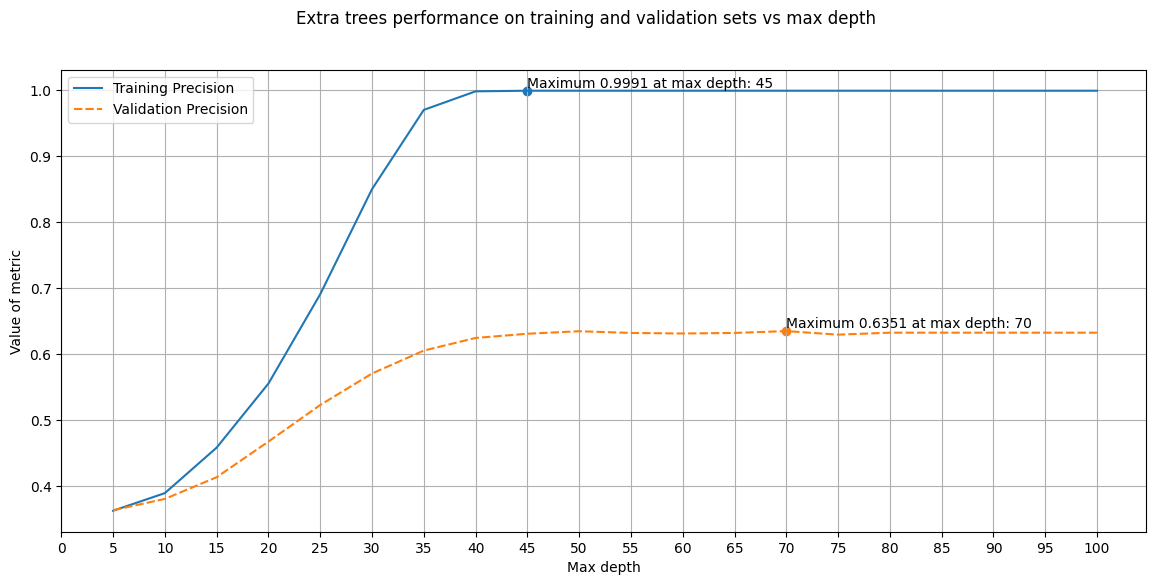

In [293]:
et_metrics = pd.DataFrame(et_metrics_dict, index=range(5, 105, 5))

fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=et_metrics,
    ax=ax
)

tr_idxmax = et_metrics['Training Precision'].idxmax()
tr_max = round(et_metrics['Training Precision'].max(), 4)
val_idxmax = et_metrics['Validation Precision'].idxmax()
val_max = round(et_metrics['Validation Precision'].max(), 4)

ax.scatter(tr_idxmax, tr_max)
ax.scatter(val_idxmax, val_max)

ax.text(tr_idxmax, tr_max+.005, f'Maximum {tr_max} at max depth: {tr_idxmax}')
ax.text(val_idxmax, val_max+.005, f'Maximum {val_max} at max depth: {val_idxmax}')

ax.set_xticks(range(0, 105, 5))
ax.set_xlabel('Max depth')
ax.set_ylabel('Value of metric')
ax.grid()

plt.suptitle(
    'Extra trees performance on training and validation sets vs max depth'
)

plt.tight_layout;

In [294]:
# Fixed extra trees classifier

et_model_fix = ens.ExtraTreesClassifier(
    n_estimators=1000,
    criterion='entropy',
    max_depth=70,
    max_features=.4,
    random_state=1234
)
et_model_fix.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

model_results(et_model_fix, X_train_final, X_val_final, y_train_final, y_val_final, False)

Model's precision for class Yes on training set: 0.9991


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,2174,0,0
Maybe,3,2170,2
Yes,0,2,2172



Model's precision for class Yes on validation set: 0.6351


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,220,103,61
Maybe,90,201,93
Yes,38,78,268


In [295]:
# Saving the model
joblib.dump(et_model_fix, 'models\\classification\\extra_trees_classifier_fixed')

['models\\classification\\extra_trees_classifier_fixed']

### Extra tree classifier

*RandomizedSearchCV* for the extra tree classifier proposed a model without the constrained hyperparameter *max_depth*, however, limiting it to 55 allows for a slightly better result on the validation set - though worse on the training set.

In [272]:
tet_clf = ExtraTreeClassifier(random_state=1234)

tet_params = {
    'criterion':['entropy'],
	'splitter':['random', 'best'],
    'max_depth':list(range(5, 55, 5)) + [None],
    'max_features':['auto'] + list(np.linspace(.1, 1, 10))
}

tet_rscv = RandomizedSearchCV(
    tet_clf, tet_params, n_iter=100, cv=5, random_state=1234, verbose=0, scoring=scorer_precision
)

tet_rscv.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

tet_rscv.best_estimator_

ExtraTreeClassifier(criterion='entropy', max_features=0.2, random_state=1234)

In [296]:
# Best extra tree classifier
tet_model = tet_rscv.best_estimator_
tet_model.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

model_results(tet_model, X_train_final, X_val_final, y_train_final, y_val_final, False)

Model's precision for class Yes on training set: 0.9991


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,2174,0,0
Maybe,3,2170,2
Yes,0,2,2172



Model's precision for class Yes on validation set: 0.5872


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,189,118,77
Maybe,103,190,91
Yes,45,100,239


In [274]:
# Saving the model
joblib.dump(tet_model, 'models\\classification\\extra_tree_classifier_best')

['models\\classification\\extra_tree_classifier_best']

In [299]:
tet_metrics_dict = {
    'Training Precision':[],
    'Validation Precision':[]
}

for i in range(5, 105, 5):
    tet_model_fix = ExtraTreeClassifier(
        criterion='entropy',
        splitter='random',
        max_depth=i,
		max_features=.2,
        random_state=1234
    )
    tet_model_fix.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

    train_precision, val_precision = model_results(
        tet_model_fix, X_train_final, X_val_final, y_train_final, y_val_final, True
    )

    tet_metrics_dict['Training Precision'].append(train_precision)
    tet_metrics_dict['Validation Precision'].append(val_precision)

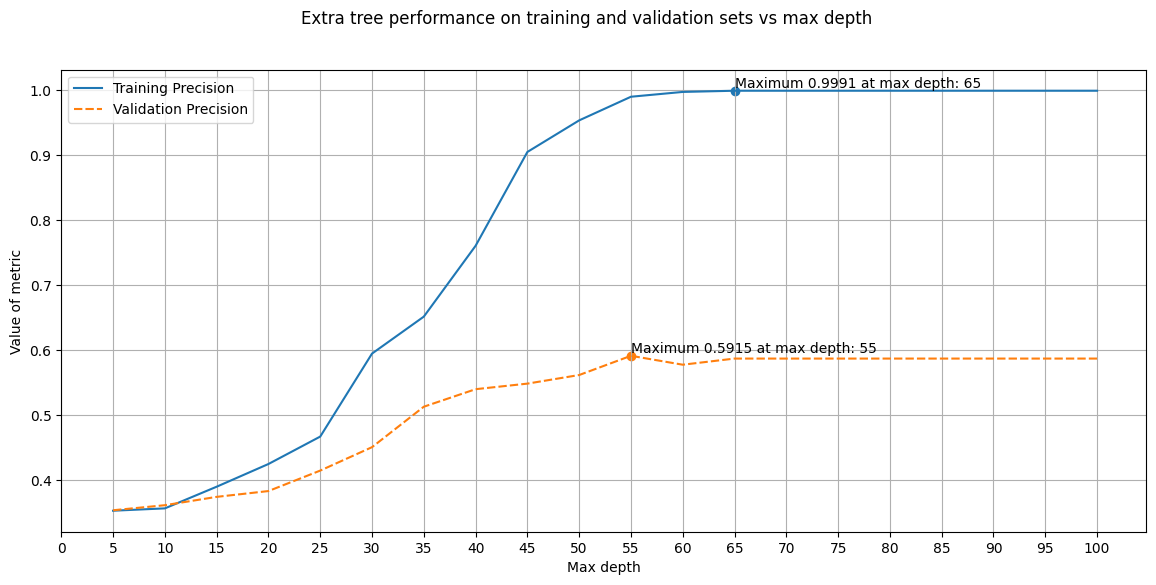

In [301]:
tet_metrics = pd.DataFrame(tet_metrics_dict, index=range(5, 105, 5))

fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=tet_metrics,
    ax=ax
)

tr_idxmax = tet_metrics['Training Precision'].idxmax()
tr_max = round(tet_metrics['Training Precision'].max(), 4)
val_idxmax = tet_metrics['Validation Precision'].idxmax()
val_max = round(tet_metrics['Validation Precision'].max(), 4)

ax.scatter(tr_idxmax, tr_max)
ax.scatter(val_idxmax, val_max)

ax.text(tr_idxmax, tr_max+.005, f'Maximum {tr_max} at max depth: {tr_idxmax}')
ax.text(val_idxmax, val_max+.005, f'Maximum {val_max} at max depth: {val_idxmax}')

ax.set_xticks(range(0, 105, 5))
ax.set_xlabel('Max depth')
ax.set_ylabel('Value of metric')
ax.grid()

plt.suptitle(
    'Extra tree performance on training and validation sets vs max depth'
)

plt.tight_layout;

In [303]:
# Fixed extra tree classifier

tet_model_fix = ExtraTreeClassifier(
    criterion='entropy',
	splitter='random',
	max_depth=55,
	max_features=.2,
	random_state=1234
)
tet_model_fix.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

model_results(tet_model_fix, X_train_final, X_val_final, y_train_final, y_val_final, False)

Model's precision for class Yes on training set: 0.9899


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,2151,14,9
Maybe,12,2150,13
Yes,9,20,2145



Model's precision for class Yes on validation set: 0.5915


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,187,130,67
Maybe,116,172,96
Yes,55,93,236


In [304]:
# Saving the model
joblib.dump(tet_model_fix, 'models\\classification\\extra_tree_classifier_fixed')

['models\\classification\\extra_tree_classifier_fixed']

### Bagging classifier

Bagging classifier provided a relatively high precision score on the validation set (0.6388), and raising the hyperparameter *max_features* to 1 allows to further improve this score slightly (to 0.6513).

In [275]:
bag_clf = ens.BaggingClassifier(random_state=1234)

bag_params = {
    'n_estimators':[1000],
    'max_samples':list(np.linspace(0, 1, 21)),
    'max_features':list(np.linspace(0, 1, 21))
}

bag_rscv = RandomizedSearchCV(
    bag_clf, bag_params, n_iter=100, cv=5, random_state=1234, verbose=0, scoring=scorer_precision
)

bag_rscv.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

bag_rscv.best_estimator_

BaggingClassifier(max_features=0.8, max_samples=0.8, n_estimators=1000,
                  random_state=1234)

In [305]:
# Best bagging classifier
bag_model = bag_rscv.best_estimator_
bag_model.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

model_results(bag_model, X_train_final, X_val_final, y_train_final, y_val_final, False)

Model's precision for class Yes on training set: 0.9982


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,2169,4,1
Maybe,1,2171,3
Yes,0,4,2170



Model's precision for class Yes on validation set: 0.6388


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,222,105,57
Maybe,84,206,94
Yes,49,68,267


In [277]:
# Saving the model
joblib.dump(bag_model, 'models\\classification\\bagging_classifier_best')

['models\\classification\\bagging_classifier_best']

In [306]:
bag_metrics_dict = {
    'Training Precision':[],
    'Validation Precision':[]
}

for i in range(1, 21):
    bag_model_fix = ens.BaggingClassifier(
        n_estimators=1000,
		max_features=i / 20,
		max_samples=.8,
        random_state=1234
    )
    bag_model_fix.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

    train_precision, val_precision = model_results(
        bag_model_fix, X_train_final, X_val_final, y_train_final, y_val_final, True
    )

    bag_metrics_dict['Training Precision'].append(train_precision)
    bag_metrics_dict['Validation Precision'].append(val_precision)

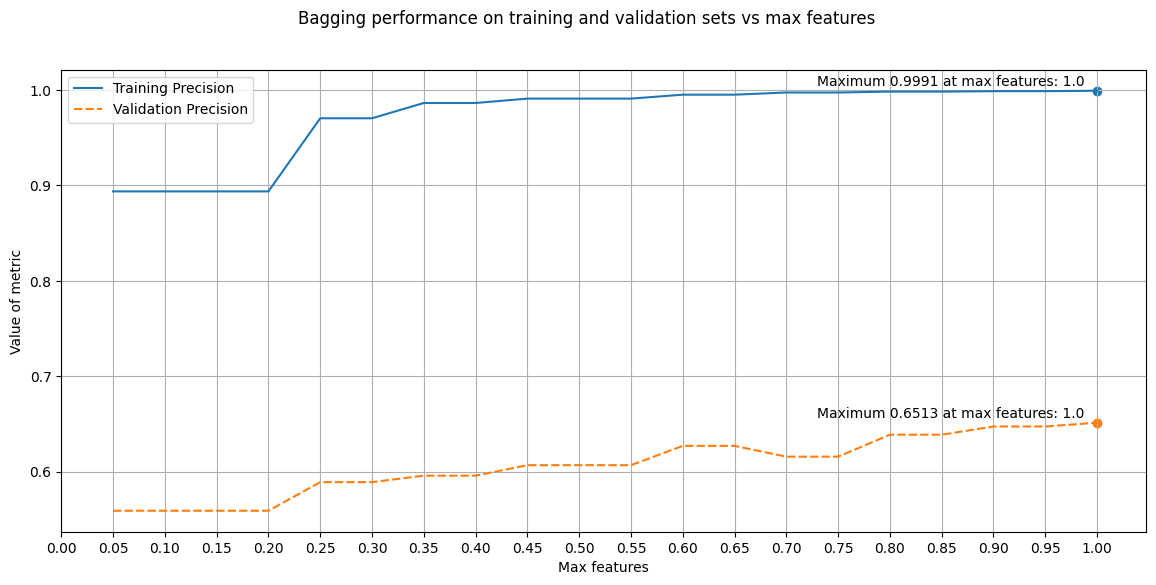

In [313]:
bag_metrics = pd.DataFrame(bag_metrics_dict, index=np.linspace(0.05, 1, 20))

fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=bag_metrics,
    ax=ax
)

tr_idxmax = bag_metrics['Training Precision'].idxmax()
tr_max = round(bag_metrics['Training Precision'].max(), 4)
val_idxmax = bag_metrics['Validation Precision'].idxmax()
val_max = round(bag_metrics['Validation Precision'].max(), 4)

ax.scatter(tr_idxmax, tr_max)
ax.scatter(val_idxmax, val_max)

ax.text(tr_idxmax-0.27, tr_max+.005, f'Maximum {tr_max} at max features: {tr_idxmax}')
ax.text(val_idxmax-0.27, val_max+.005, f'Maximum {val_max} at max features: {val_idxmax}')

ax.set_xticks(np.linspace(0, 1, 21))
ax.set_xlabel('Max features')
ax.set_ylabel('Value of metric')
ax.grid()

plt.suptitle(
    'Bagging performance on training and validation sets vs max features'
)

plt.tight_layout;

In [316]:
# Fixed bagging classifier

bag_model_fix = ens.BaggingClassifier(
    n_estimators=1000,
    max_samples=.8,
    random_state=1234
)
bag_model_fix.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

model_results(bag_model_fix, X_train_final, X_val_final, y_train_final, y_val_final, False)

Model's precision for class Yes on training set: 0.9991


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,2171,3,0
Maybe,0,2173,2
Yes,0,2,2172



Model's precision for class Yes on validation set: 0.6513


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,223,109,52
Maybe,89,203,92
Yes,52,63,269


In [317]:
# Saving the model
joblib.dump(bag_model_fix, 'models\\classification\\bagging_classifier_fixed')

['models\\classification\\bagging_classifier_fixed']

### XGB classifier

The last model, the XGB classifier, gave relatively poor results, while manipulation of the *max_depth* hyperparameter does not improve them.

In [278]:
xgb_clf = xgb.XGBClassifier(random_state=1234, objective='multi:softmax', num_class=3)

xgb_params = {
    'eta':list(np.linspace(.01, .1, 10)),
    'gamma':list(range(16)),
    'max_depth':list(range(5, 55, 5)),
    'subsample':list(np.linspace(0, 1, 11)),
    'colsample_bytree':list(np.linspace(0, 1, 11)),
    'reg_alpha':list(range(11)),
    'reg_lambda':list(range(11)),
    'num_leaves':list(range(100, 3100, 100)),
    'n_estimators':[1000]
}

xgb_rscv = RandomizedSearchCV(
    xgb_clf, xgb_params, n_iter=100, cv=5, random_state=1234, verbose=0, scoring=scorer_precision
)

xgb_rscv.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

xgb_rscv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.030000000000000006, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0299999993,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=25, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_class=3, num_leaves=1000, ...)

In [318]:
# Best XGB classifier
xgb_model = xgb_rscv.best_estimator_
xgb_model.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

model_results(xgb_model, X_train_final, X_val_final, y_train_final, y_val_final, False)

Model's precision for class Yes on training set: 0.7851


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,1667,310,197
Maybe,287,1587,301
Yes,134,221,1819



Model's precision for class Yes on validation set: 0.5856


Prediction:,No,Maybe,Yes
Interesting investment:,,,
No,198,117,69
Maybe,99,187,98
Yes,76,72,236


In [280]:
# Saving the model
joblib.dump(xgb_model, 'models\\classification\\xgb_classifier_best')

['models\\classification\\xgb_classifier_best']

In [319]:
xgb_metrics_dict = {
    'Training Precision':[],
    'Validation Precision':[]
}

for i in range(5, 105, 5):
    xgb_model_fix = xgb.XGBClassifier(
        eta=.03,
        gamma=1,
        max_depth=i,
        subsample=.9,
        colsample_bytree=.8,
        reg_alpha=4,
        reg_lambda=6,
        num_leaves=1000,
        n_estimators=1000,
        random_state=1234,
        objective='multi:softmax',
        num_class=3
    )
    xgb_model_fix.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

    train_precision, val_precision = model_results(
        xgb_model_fix, X_train_final, X_val_final, y_train_final, y_val_final, True
    )

    xgb_metrics_dict['Training Precision'].append(train_precision)
    xgb_metrics_dict['Validation Precision'].append(val_precision)

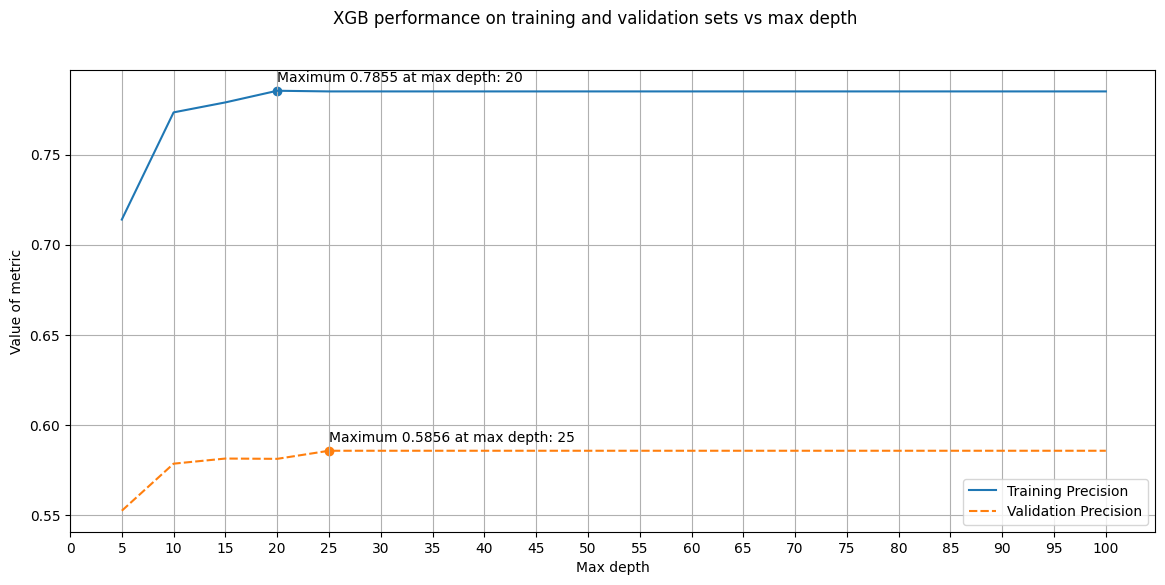

In [322]:
xgb_metrics = pd.DataFrame(xgb_metrics_dict, index=range(5, 105, 5))

fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=xgb_metrics,
    ax=ax
)

tr_idxmax = xgb_metrics['Training Precision'].idxmax()
tr_max = round(xgb_metrics['Training Precision'].max(), 4)
val_idxmax = xgb_metrics['Validation Precision'].idxmax()
val_max = round(xgb_metrics['Validation Precision'].max(), 4)

ax.scatter(tr_idxmax, tr_max)
ax.scatter(val_idxmax, val_max)

ax.text(tr_idxmax, tr_max+.005, f'Maximum {tr_max} at max depth: {tr_idxmax}')
ax.text(val_idxmax, val_max+.005, f'Maximum {val_max} at max depth: {val_idxmax}')

ax.set_xticks(range(0, 105, 5))
ax.set_xlabel('Max depth')
ax.set_ylabel('Value of metric')
ax.grid()

plt.suptitle(
    'XGB performance on training and validation sets vs max depth'
)

plt.tight_layout;

### Stacking

In the last step, we will try to combine the obtained models into one, using another random forest classifier as a meta learner. The highest precision score was achieved by combining random forest, extra trees and extra tree classifiers, however, it achieved a lower score on the validation set (0.6456) than the random forest classifier alone (0.6602).

In [323]:
# Stacking
model_list = [
    ('extra_trees', et_model_fix),
    ('random_forest', rf_model_fix),
    ('extra_tree', tet_model_fix),
    ('bagging', bag_model_fix),
    ('xgb', xgb_model)
]

comb_model_list = []
for i in range(2, 6):
    for comb in combinations(model_list, i):
        comb_model_list.append(comb)

model_results_dict = {}
for i, model_set in enumerate(comb_model_list):
    model_names = [model[0] for model in model_set]

    stacked_model = ens.StackingClassifier(
        estimators=model_set,
        final_estimator=ens.RandomForestClassifier(random_state=1234),
        cv=5
    )

    stacked_model.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

    train_precision, val_precision = model_results(
        stacked_model, X_train_final, X_val_final, y_train_final, y_val_final, True
    )

    model_results_dict[', '.join(model_names)] = [train_precision, val_precision]

In [324]:
model_results_df = pd.DataFrame(
    model_results_dict,
    index=['Training Precision', 'Validation Precision']
).transpose()
model_results_df

,Training Precision,Validation Precision
"extra_trees, random_forest",0.9042,0.6331
"extra_trees, extra_tree",0.9972,0.6221
"extra_trees, bagging",0.8598,0.6221
"extra_trees, xgb",0.9164,0.6238
"random_forest, extra_tree",0.8950,0.6044
"random_forest, bagging",0.9293,0.6032
"random_forest, xgb",0.9547,0.6101
"extra_tree, bagging",0.8849,0.5765
"extra_tree, xgb",0.7677,0.5678
"bagging, xgb",0.9413,0.6095


In [325]:
train_precision_max = model_results_df['Training Precision'].max()
train_precision_max_id = model_results_df['Training Precision'].idxmax()
val_precision_max = model_results_df['Validation Precision'].max()
val_precision_max_id = model_results_df['Validation Precision'].idxmax()

print(f'Maximum training precision is {round(train_precision_max, 4)} '\
    f'for {train_precision_max_id} model.')
print(f'Maximum validation precision is {round(val_precision_max, 4)} '\
    f'for {val_precision_max_id} model.')

Maximum training precision is 0.9972 for extra_trees, extra_tree model.
Maximum validation precision is 0.6456 for extra_trees, random_forest, extra_tree model.


In [326]:
stacked_model = ens.StackingClassifier(
    estimators=[
        ('random_forest', rf_model_fix),
        ('extra_trees', tet_model_fix),
        ('extra_tree', et_model_fix)
    ],
    final_estimator=ens.RandomForestClassifier(random_state=1234),
    cv=5
)

stacked_model.fit(X_train_final, y_train_num, sample_weight=train_classes_weight)

StackingClassifier(cv=5,
                   estimators=[('random_forest',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=35,
                                                       max_features=0.4,
                                                       n_estimators=1000,
                                                       random_state=1234)),
                               ('extra_trees',
                                ExtraTreeClassifier(criterion='entropy',
                                                    max_depth=55,
                                                    max_features=0.2,
                                                    random_state=1234)),
                               ('extra_tree',
                                ExtraTreesClassifier(criterion='entropy',
                                                     max_depth=70,
                                                     max_features=0.4,
                                                     n_estimators=1000,
                                                     random_state=1234))],
                   final_estimator=RandomForestClassifier(random_state=1234))

In [327]:
# Saving the model
joblib.dump(stacked_model, 'models\\classification\\stacked_model')

['models\\classification\\stacked_model']

All the models analyzed gave similar results on the validation and test sets. In particular, the random forest classifier on the validation set achieved a precision score  of 0.6602, while on the test set: 0.6518. In further analysis, we will only use the random forest classifier now.

In [330]:
# Model list for test set
test_list = [
    ('extra_trees', et_model_fix),
    ('random_forest', rf_model_fix),
    ('extra_tree', tet_model_fix),
    ('bagging', bag_model_fix),
    ('xgb', xgb_model),
    ('stacked_model', stacked_model)
]

for model in test_list:
    val_precision, test_precision = model_results(
        model[1], X_val_final, X_test_final, y_val_final, y_test_final, True
    )
    
    print(f'{model[0]} performance:')
    print(f'Validation precision: {round(val_precision, 4)}, '\
        f'test precision: {round(test_precision, 4)}, '\
        f'absolute difference: {round(abs(val_precision - test_precision), 4)}\n') 


extra_trees performance:
Validation precision: 0.6351, test precision: 0.6547, absolute difference: 0.0196

random_forest performance:
Validation precision: 0.6602, test precision: 0.6518, absolute difference: 0.0084

extra_tree performance:
Validation precision: 0.5915, test precision: 0.5744, absolute difference: 0.0171

bagging performance:
Validation precision: 0.6513, test precision: 0.6396, absolute difference: 0.0118

xgb performance:
Validation precision: 0.5856, test precision: 0.5886, absolute difference: 0.0029

stacked_model performance:
Validation precision: 0.6308, test precision: 0.6212, absolute difference: 0.0096



In [6]:
# Loading the best model
rf_model_fix = joblib.load('models\\classification\\random_forest_classifier_fixed')

# Explanatory model analysis

In this part of the analysis, we will assess which variables were most significant for the random forest classifier - the permutation-based variable-importance evaluation method will help. A definite standout here is **long_term_investment_per_share** and **core_capital**. Next in importance are the variables **supplementary_capital** and **core_capital_per_share**. In contrast, the variables **price** and **company_value_per_share** only slightly affected the model results.

In [7]:
# Model explainers
rf_model_fix_exp = dx.Explainer(
    rf_model_fix, X_train_final, y_train_num, verbose=False, label='Random forest')

In [332]:
# Model parts
rf_model_fix_mp = rf_model_fix_exp.model_parts()

In [333]:
rf_model_fix_mp.plot()

## Instance-level exploration

Let's focus on the observations that the model has labeled *Yes*. The charts below show what percentage of observations with a given label were correctly classified (the percentages add up column-wise). On the training set, 100% of the observations correctly received such a label. On the validation and test sets, these percentages are much worse: only about two thirds of the observations were correctly classified as *Yes*, while about 15% of the observations that the model judged as good investment opportunities would yield a loss. Recall that for the best regression model, this percentage was 7.68%.

In [8]:
# Bagging predictions
X_val_test_final = pd.concat([X_val_final, X_test_final])
y_val_test_final = pd.concat([y_val_final, y_test_final])

train_pred = pd.DataFrame(
    rf_model_fix.predict(X_train_final), columns=['prediction'], index=X_train_final.index)
val_pred = pd.DataFrame(
    rf_model_fix.predict(X_val_final), columns=['prediction'], index=X_val_final.index)
test_pred = pd.DataFrame(
    rf_model_fix.predict(X_test_final), columns=['prediction'], index=X_test_final.index)
val_test_pred = pd.DataFrame(
    rf_model_fix.predict(X_val_test_final), columns=['prediction'], index=X_val_test_final.index)

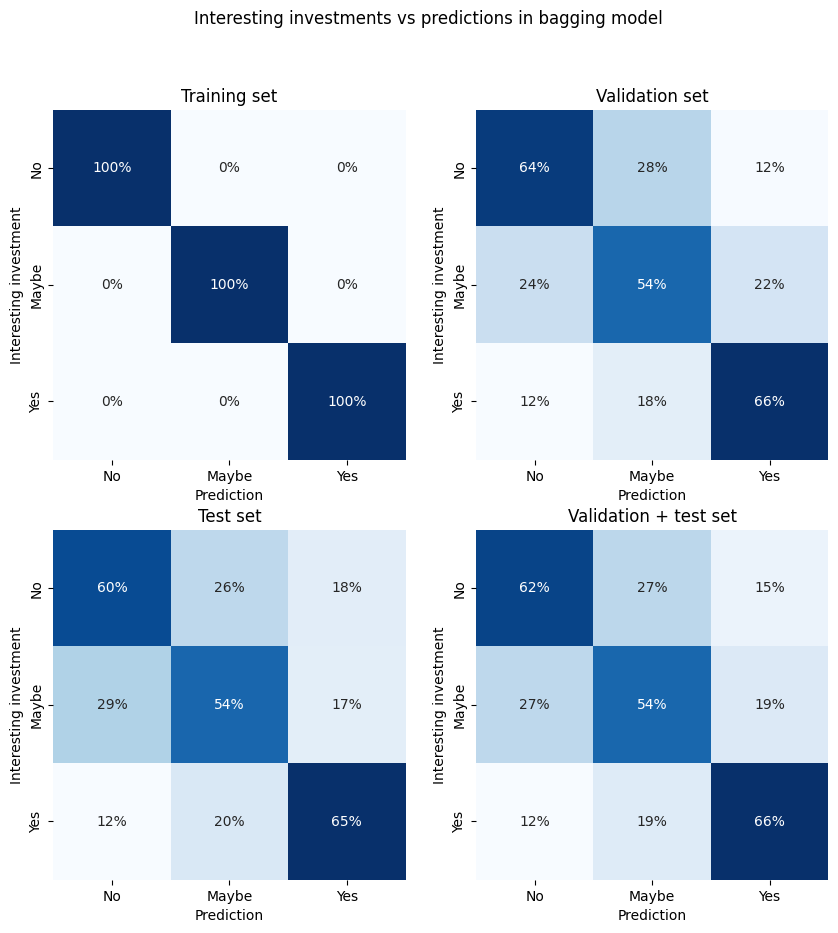

In [9]:
fig, axs = plt.subplots(2, 2, figsize = (10, 10))

sns.heatmap(
    data=pd.crosstab(
        y_train_final.interesting_investment,
        train_pred.replace({'prediction':{0:'No', 1:'Maybe', 2:'Yes'}}).prediction,
        rownames=['Interesting investment:'],
        colnames=['Prediction:'],
        normalize='columns'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    cmap='Blues',
    fmt='.0%',
    annot=True,
    cbar=False,
    ax=axs[0, 0]
)

sns.heatmap(
    data=pd.crosstab(
        y_val_final.interesting_investment,
        val_pred.replace({'prediction':{0:'No', 1:'Maybe', 2:'Yes'}}).prediction,
        rownames=['Interesting investment:'],
        colnames=['Prediction:'],
        normalize='columns'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    cmap='Blues',
    fmt='.0%',
    annot=True,
    cbar=False,
    ax=axs[0, 1]
)

sns.heatmap(
    data=pd.crosstab(
        y_test_final.interesting_investment,
        test_pred.replace({'prediction':{0:'No', 1:'Maybe', 2:'Yes'}}).prediction,
        rownames=['Interesting investment:'],
        colnames=['Prediction:'],
        normalize='columns'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    cmap='Blues',
    fmt='.0%',
    annot=True,
    cbar=False,
    ax=axs[1, 0]
)

sns.heatmap(
    data=pd.crosstab(
        y_val_test_final.interesting_investment,
        val_test_pred.replace({'prediction':{0:'No', 1:'Maybe', 2:'Yes'}}).prediction,
        rownames=['Interesting investment:'],
        colnames=['Prediction:'],
        normalize='columns'
    ).reindex(['No', 'Maybe', 'Yes'], axis=1),
    cmap='Blues',
    fmt='.0%',
    annot=True,
    cbar=False,
    ax=axs[1, 1]
)

for i in range(2):
    for j in range(2):
        axs[i, j].set_ylabel('Interesting investment')
        axs[i, j].set_xlabel('Prediction')

axs[0, 0].set_title('Training set')
axs[0, 1].set_title('Validation set')
axs[1, 0].set_title('Test set')
axs[1, 1].set_title('Validation + test set')
plt.suptitle('Interesting investments vs predictions in bagging model')

plt.tight_layout;

Let's look at the four observations that had the lowest value of the **final_price_dynamics** variable in the test set, but were classified by the model as those that would yield a profit of 50%. In the first of these, the relatively low values of the **price** (between the 10th and 15th percentiles) and **number_of_shares** (between the 15th and 20th percentiles) variables had the greatest (negative) impact on prediction.

In [12]:
dataset_preproc.final_price_dynamics

11243   -0.5035
13846   -0.2399
7148    -0.2273
14206   -0.1909
11557   -0.2263
          ...  
18518    0.5000
18519    0.5000
18520    0.5000
18521    0.5000
18522    0.5000
Name: final_price_dynamics, Length: 9030, dtype: float64

In [16]:
overestimated_test = pd.concat([X_test_final, y_test_final, test_pred], axis=1)
overestimated_test = pd.merge(
    overestimated_test,
    dataset_preproc.final_price_dynamics,
    how='left',
    left_index=True,
    right_index=True
)
overestimated_test = overestimated_test[
    (y_test_final.interesting_investment == 'No') &
    (test_pred.replace({'prediction':{0:'No', 1:'Maybe', 2:'Yes'}}).prediction == 'Yes')
]

overestimated_test = overestimated_test.sort_values(by=['final_price_dynamics'])
overestimated_test

,company_value,company_value_per_share,core_capital,core_capital_per_share,long_term_investment_per_share,number_of_shares,price,supplementary_capital,supplementary_capital_per_share,interesting_investment,prediction,final_price_dynamics
7295,-0.0543,-0.0899,-0.1510,-0.0702,-0.0705,-0.1482,-0.1441,-0.2200,-0.1253,No,2,-0.6113
1131,-0.0543,-0.0899,-0.1313,-0.0702,-0.0220,-0.1120,-0.1296,-0.2207,-0.1456,No,2,-0.5854
1027,-0.0543,-0.0899,-0.1162,-0.0702,-0.0525,-0.0842,-0.0767,-0.2066,-0.1421,No,2,-0.5733
3493,-0.0543,-0.0899,-0.1511,-0.0812,-0.0715,-0.1430,-0.1337,-0.2028,-0.1003,No,2,-0.5464
1558,-0.0543,-0.0899,-0.1421,-0.0702,-0.0699,-0.1319,-0.1011,-0.2038,-0.1255,No,2,-0.5265
...,...,...,...,...,...,...,...,...,...,...,...,...
8183,-0.0479,-0.0849,-0.1462,-0.0899,-0.0371,-0.0101,-0.1428,-0.0308,-0.1172,No,2,-0.0329
10554,-0.0539,-0.0887,-0.1516,-0.0899,-0.0715,-0.1086,-0.1457,-0.2001,-0.1353,No,2,-0.0195
554,-0.0543,-0.0896,-0.1466,2.0181,-0.0715,-0.1538,1.8714,-0.2154,1.5169,No,2,-0.0035
5006,-0.0543,-0.0899,-0.1533,-0.0899,-0.0715,-0.1393,-0.1169,-0.2061,-0.1175,No,2,-0.0029


In [17]:
int_break_down = []
for i in range(4):
    int_break_down.append(
        rf_model_fix_exp.predict_parts(
            overestimated_test.iloc[i, :9], type='break_down_interactions'
        )
    )

In [18]:
print(f'Analysis of observation {overestimated_test.index[0]}')
int_break_down[0].plot()

Analysis of observation 7295


For the next observation, the value of the **price** variable was between the 55th and 60th percentile, but had a significant negative impact on the prediction. On the other hand, the combination of variables **long_term_investment_per_share** and **core_capital** had the greatest positive impact on the result. The first of these variables was relatively high (between the 85th and 90th percentile), while the value of the second was between the 65th and 70th percentile.

In [19]:
print(f'Analysis of observation {overestimated_test.index[1]}')
int_break_down[1].plot()

Analysis of observation 1131


In the third observation, the combination of **number_of_shares** and **long_term_investment_per_share** variables played a key role and had a negative impact on the prediction value (as did the other variables). The number of shares was relatively high, as was the value of long-term investment per share or share price (another variable relevant to this prediction).

In [20]:
print(f'Analysis of observation {overestimated_test.index[2]}')
int_break_down[2].plot()

Analysis of observation 1027


In the last observation, **price** was the most important variable, however, its value was between the 45th and 50th percentiles. The next most important variables were **core_capital** and **core_capital_per_share**, while their values were between the 35th and 40th percentiles.

In [21]:
print(f'Analysis of observation {overestimated_test.index[3]}')
int_break_down[3].plot()

Analysis of observation 3493


# Comparison with the gurus' strategies

As a final step, let's check how obtained model performed against gurus' strategies. In the analysis, we will use the combined validation and test sets to have a sufficient number of observations.

One of the assumptions made in analysis of gurus' strategies was the criterion of portfolio size - in at least 80% of the quarters analyzed, we had to have at least 10 companies in the portfolio. For random forest model, this condition was met by a wide margin - the created portfolio had more than 10 companies for almost 93% of the quarters analyzed.

In [42]:
prediction_df = pd.concat(
    [y_val_test_final, val_test_pred],
    axis=1
)

prediction_df = prediction_df.merge(
    dataset_preproc.filter(
        [
            'quarter', 'sold_in_q', 'final_wig_dynamics', 'final_price_dynamics'
        ]
    ),
    left_index=True,
    right_index=True
)

In [43]:
portfolio_size_df = pd.DataFrame(index=sorted(dataset_preproc.quarter.unique()))

temp_set = pd.DataFrame(
    pd.Series(
        prediction_df[
            prediction_df.prediction == 2
        ].groupby('quarter').quarter.count().reindex(portfolio_size_df.index).fillna(0),
        name='buy'
    )
)
temp_set['sell'] = pd.Series(
    prediction_df[
        prediction_df.prediction == 2
    ].groupby('sold_in_q').sold_in_q.count().reindex(portfolio_size_df.index).fillna(0),
)

portfolio_size_df['Size'] = (
    temp_set.buy - temp_set.sell
).cumsum().astype(int)

In [44]:
print('Percentage of quarters with portfolio size over 10 in random forest model:')
100 * (
    portfolio_size_df[portfolio_size_df >= 10].count()
    / portfolio_size_df.shape[0]
)

Percentage of quarters with portfolio size over 10 in random forest model:


Size   92.6471
dtype: float64

In [45]:
prediction_df['buy'] = np.where(prediction_df.prediction == 2, 'Yes', 'No')

## Random forest model

The dataset analyzed included 835 observations that made at least 50% profit within a year of purchase, and the random forest model valued their profit at at least 50% in 587 cases. The model sent 895 buy signals, of which 135 would end in a loss, while 173 would end in a profit of less than 50%.

Random forest model won with gurus' strategies on every field. It indicated smaller percentage of buy signals that ended in loss (15%) and larger percentage of signals that ended in profit at 50% (66%). The model beat the zero effort strategy in 56 quarters, ultimately achieving an average investment return of 25.12%.

In [48]:
print('\nInteresting companies in random forest model:')
print(prediction_df.interesting_investment.value_counts())
print(
    f'\nNumber of buy signals from random forest model: {prediction_df.buy.value_counts()[1]}'
)


Interesting companies in random forest model:
No       836
Yes      836
Maybe    835
Name: interesting_investment, dtype: int64

Number of buy signals from random forest model: 895


In [49]:
pd.crosstab(
    prediction_df.interesting_investment,
    prediction_df.buy,
    rownames=['Interesting investment:'],
    colnames=['Buy signal from random forest model']
).reindex(['No', 'Maybe', 'Yes'], axis=0)

Buy signal from random forest model,No,Yes
Interesting investment:,,
No,701,135
Maybe,662,173
Yes,249,587


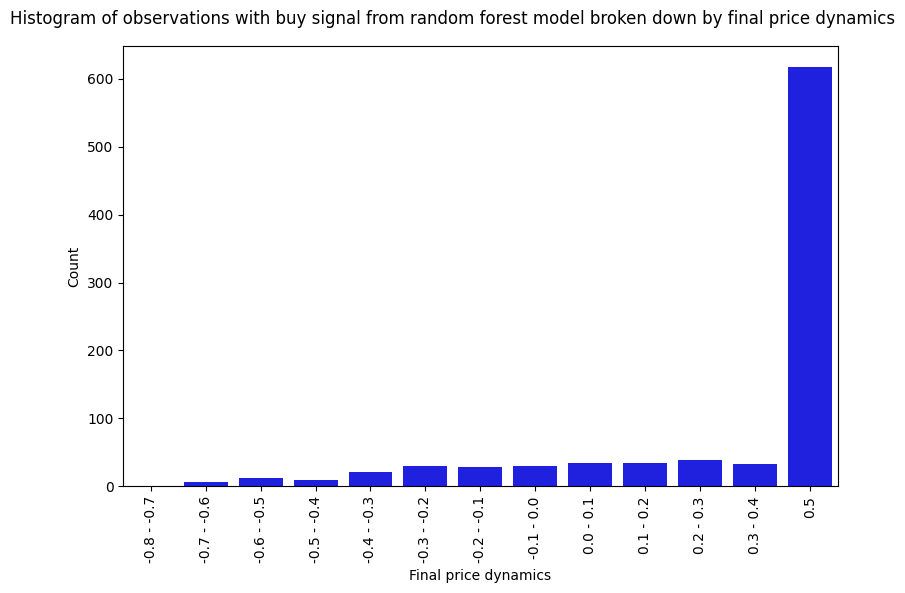

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(
    x=pd.cut(
        prediction_df[prediction_df.buy == 'Yes'].final_price_dynamics,
        bins=list(np.linspace(-.8, .5, 14)),
        labels=[f'{round(i, 1)} - {round(i + .1, 1)}' for i in np.linspace(-.8, .3, 12)] + ['0.5']
    ),
    color='blue',
    ax=ax
)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('Final price dynamics')
ax.set_ylabel('Count')

plt.suptitle(
    'Histogram of observations with buy signal from '\
    'random forest model broken down by final price dynamics'
)

plt.tight_layout();

In [51]:
return_df = pd.DataFrame({
    'Zero effort strategy':dataset_preproc.groupby('quarter').final_wig_dynamics.mean(),
    'Random forest model':prediction_df[
        prediction_df.buy == 'Yes'
    ].groupby('quarter').final_price_dynamics.mean()
})

quarters_strat = return_df['Random forest model'].count()

portfolio_size = portfolio_size_df[
    portfolio_size_df['Size'] >= 10
]['Size'].count()

quarters_profit_strat_var = return_df[
    return_df['Random forest model'] > 0
]['Random forest model'].count()

quarters_profit_wig = return_df[
    return_df['Zero effort strategy'] > 0
]['Zero effort strategy'].count()

quarters_perform_strat_var = return_df[
    return_df['Random forest model'] > return_df['Zero effort strategy']
]['Random forest model'].count()

avg_strategy_return_var = (100 * return_df['Random forest model'].mean()).round(2)

avg_wig_return =(100 * return_df['Zero effort strategy'].mean()).round(2)

print(f'Number of quarters with buy signal from random forest model: {quarters_strat}')
print(f'Number of quarters with sufficient portfolio size: {portfolio_size}')
print(f'Number of profitable quarters using random forest model: {quarters_profit_strat_var}')
print(f'Number of profitable quarters using zero effort strategy: {quarters_profit_wig}')
print(
    'Number of quarters in which '\
    f'random forest model outperformed zero effort strategy: {quarters_perform_strat_var}'
)
print(f'Average return on random forest model: {avg_strategy_return_var}%')
print(f'Average return on zero effort strategy: {avg_wig_return}%')

Number of quarters with buy signal from random forest model: 65
Number of quarters with sufficient portfolio size: 63
Number of profitable quarters using random forest model: 57
Number of profitable quarters using zero effort strategy: 43
Number of quarters in which random forest model outperformed zero effort strategy: 56
Average return on random forest model: 25.12%
Average return on zero effort strategy: 5.87%


# Summary

The classification model proved superior to each of the gurus' strategies. However, when compared to regression models, it performs slightly worse. The percentage of buy signals that would end in a loss is higher in the random forest model (15.08%) than in the regression models (7.68% and 10.73%). Also, the percentage of quarters in which the strategy based on the classification model resulted in losses was about twice as high (12.12%) as in the regression models (6.45% and 5%). On the other hand, the random forest model provided a higher percentage of buy signals that would end with a profit of 50% (65.59%, in regression models: 54.14% and 51.42%). In the end, however, the classification model achieved a slightly lower average return: 25.12%. Compared to the zero effort strategy, the classification model generally behaves better than the stock market in quarters where WIG growth was negative. The exceptions were Q2-Q4 2007 and Q3 2010. Analyzing the quarters in which the strategy based on the random forest model made losses, we can see that the small number of buy signals did not affect the average negative final price dynamics.

In [54]:
# Data frame with return on investment
summary_return_df = pd.DataFrame({
    'Zero effort strategy':dataset_preproc.groupby('quarter').final_wig_dynamics.mean(),
    'Random forest model':prediction_df[
        prediction_df.buy == 'Yes'].groupby('quarter').final_price_dynamics.mean()
})

In [55]:
# Final statistics
statistics_df = pd.DataFrame(index=[
    'Percentage of loss-making investments',
    'Percentage of profitable investments (below 50%)',
    'Percentage of profitable investments (50%)',
    'Percentage of loss-making quarters',
    'Percentage of profitable quarters',
    'Average return (%)',
    'Percentage of quarters in which strategy outperformed zero effort strategy'
])

buy_names = ['mod_zweig_buy', 'mod_kirkpatrick_buy']

for i, strategy in enumerate(summary_return_df.columns):
    values = []

    if strategy == 'Zero effort strategy':
        values.append('-')
        values.append('-')
        values.append('-')
    else:
        signals = prediction_df.buy.value_counts()[1]
        ctab = pd.crosstab(
            prediction_df.interesting_investment,
            prediction_df.buy
        ).reindex(['No', 'Maybe', 'Yes'], axis=0)
        # Percentage of loss-making investments
        values.append(round(100 * ctab.iloc[0, 1] / signals, 2))
        # Percentage of profitable investments < 50%
        values.append(round(100 * ctab.iloc[1, 1] / signals, 2))
        # Percentage of profitable investments == 50%
        values.append(round(100 * ctab.iloc[2, 1] / signals, 2))

    # Number of NaNs in summary_return_df
    nan_num = summary_return_df[strategy].isna().sum()

    # Percentage of loss-making quarters
    values.append(
        round(
            100 * summary_return_df[
                summary_return_df[strategy] < 0][strategy].count() / (69 - nan_num), 2
        )
    )
    # Percentage of profitable quarters
    values.append(
        round(
            100 * summary_return_df[
                summary_return_df[strategy] > 0][strategy].count() / (69 - nan_num), 2
        )
    )
    # Average return
    values.append((100 * summary_return_df[strategy].mean()).round(2))

    if strategy == 'Zero effort strategy':
        values.append('-')
    else:
        # Percentage of quarters in which strategy outperformed zero effort strategy
        values.append(
            round(
                100 * summary_return_df[summary_return_df[strategy] > 0][strategy].count() / 69, 2)
        )

    statistics_df[strategy] = values

statistics_df

,Zero effort strategy,Random forest model
Percentage of loss-making investments,-,15.0800
Percentage of profitable investments (below 50%),-,19.3300
Percentage of profitable investments (50%),-,65.5900
Percentage of loss-making quarters,36.2300,12.1200
Percentage of profitable quarters,62.3200,86.3600
Average return (%),5.8700,25.1200
Percentage of quarters in which strategy outperformed zero effort strategy,-,82.6100


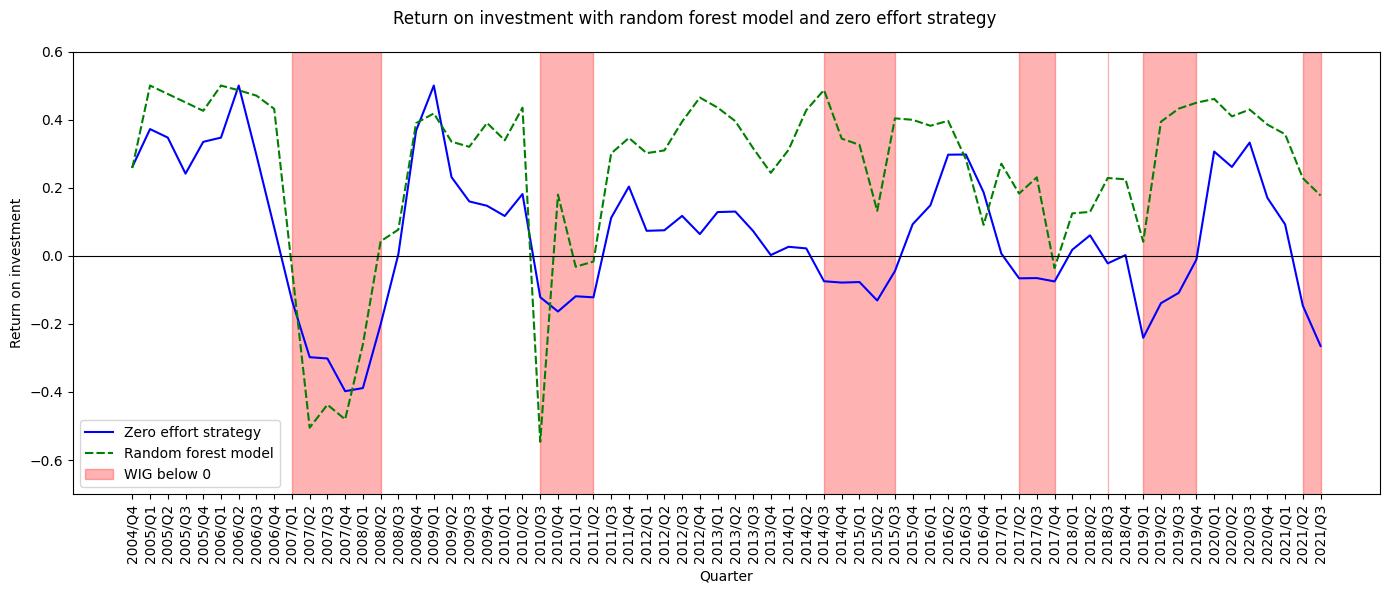

In [56]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(
    data=summary_return_df.filter([
        'Zero effort strategy',
        'Random forest model'
    ]),
    palette=['blue', 'green'],
    ax=ax
)

ax.fill_between(
    range(68), -0.5, 1,
    where=summary_return_df['Zero effort strategy'] < 0,
    color='red', alpha=0.3, transform=ax.get_xaxis_transform(),
    label='WIG below 0'
)

ax.axhline(0, color='black', linewidth=.8)

ax.tick_params(axis='x', labelrotation=90)

ax.set_ylim([-.7, .6])

handles, _ = ax.get_legend_handles_labels()
plt.legend(
    handles = handles,
    labels = [
        'Zero effort strategy',
        'Random forest model',
        'WIG below 0'
    ]
)

ax.set_ylabel('Return on investment')
ax.set_xlabel('Quarter')

plt.suptitle(
    'Return on investment with random forest model and zero effort strategy')

plt.tight_layout();

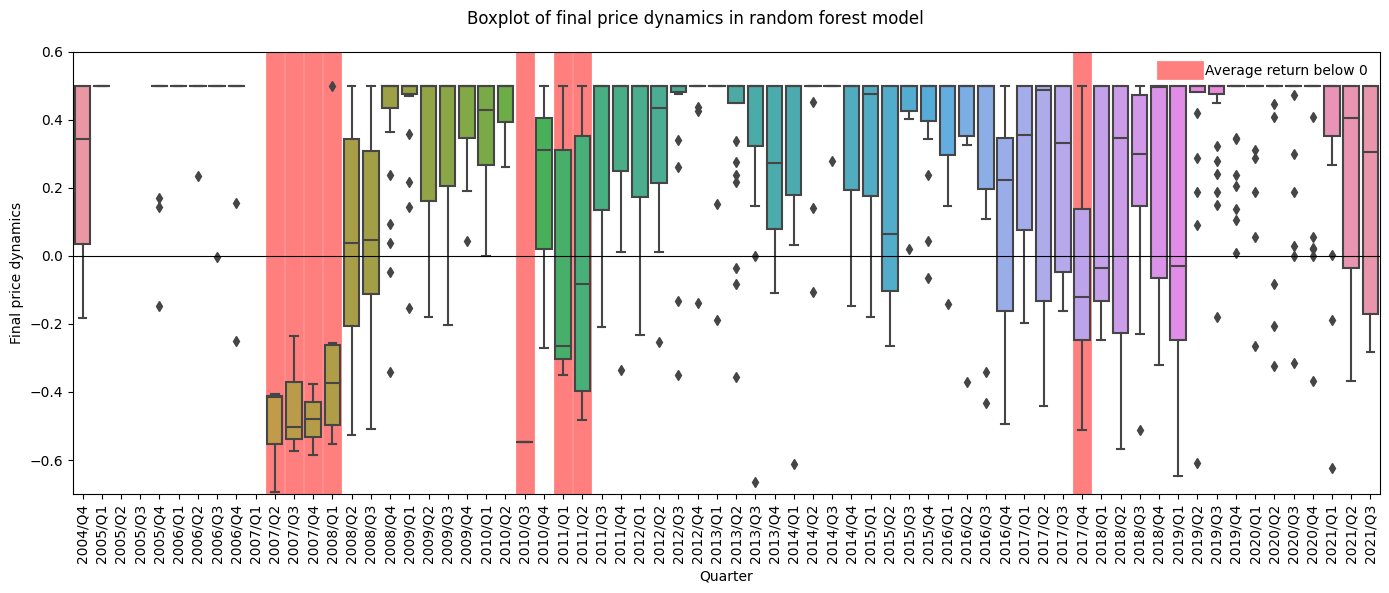

In [58]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.boxplot(
    x=prediction_df[prediction_df.buy == 'Yes'].quarter,
    y=prediction_df[prediction_df.buy == 'Yes'].final_price_dynamics,
    order=sorted(dataset_preproc.quarter.unique()),
    ax=ax
)

for i, quarter in enumerate(
    summary_return_df[summary_return_df['Random forest model'] < 0].index.tolist()
):
    if i == 0:
        ax.axvline(
            summary_return_df.index.tolist().index(quarter),
            color='red', linewidth=13.5, zorder=0, alpha=.5,
            label=f'Average return below 0'
        )
    else:
        ax.axvline(
            summary_return_df.index.tolist().index(quarter),
            color='red', linewidth=13.5, zorder=0, alpha=.5
        )

ax.legend(frameon=False)

ax.axhline(0, color='black', linewidth=.8)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim([-.7, .6])

ax.set_ylabel('Final price dynamics')
ax.set_xlabel('Quarter')

plt.suptitle('Boxplot of final price dynamics in random forest model')

plt.tight_layout();